# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Sales Prediction for *Rossmann*

----
## Load the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'Sales'`, will be our target label . All other columns are features about each individual in the train database.

In [1]:
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")

# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from pandas import datetime

import operator
import matplotlib
matplotlib.use("Agg") #Needed to save figures
# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline


# label encoder
from sklearn import preprocessing
# Import train_test_split
from sklearn.model_selection import train_test_split
# create a decorater to measure the model training and predicting elapsed time
import time
from sklearn.metrics import mean_squared_error
# For Random Forest parameters
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV
# algorithms input

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
# Set up XGBoost parameters
import scipy.stats as st

D:\ProgramData\Anaconda3\envs\py3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\ProgramData\Anaconda3\envs\py3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
types = {'CompetitionOpenSinceYear': np.dtype(int),
         'CompetitionOpenSinceMonth': np.dtype(int),
         'StateHoliday': np.dtype(str),
         'Promo2SinceWeek': np.dtype(int),
         'SchoolHoliday': np.dtype(float),
         'PromoInterval': np.dtype(str)}
# Load the dataset
train = pd.read_csv("train.csv",parse_dates=['Date'], dtype=types)
# Load test data
test = pd.read_csv("test.csv",parse_dates=['Date'], dtype=types)
# load additional store data
store = pd.read_csv("store.csv")


** Featureset Exploration **

* **Id** - an Id that represents a (Store, Date) duple within the test set
* **Store** - a unique Id for each store
* **Sales** - the turnover for any given day (this is what you are predicting)
* **Customers** - the number of customers on a given day
* **Open** - an indicator for whether the store was open: 0 = closed, 1 = open
* **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools
* **StoreType** - differentiates between 4 different store models: a, b, c, d
* **Assortment**- describes an assortment level: a = basic, b = extra, c = extended
* **CompetitionDistance** - distance in meters to the nearest competitor store
* **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
* **Promo** - indicates whether a store is running a promo on that day
* **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
* **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

----
## Exploratory Data Analysis
Exploratory data analysis helps data scientist get a general idea and required processes about the dataset.  

In [3]:
# input extra features
# keep all the information
data=pd.merge(train,store,on='Store',how='outer')

In [4]:
# data extraction basic
data['Year'] = data.Date.dt.year
data['Month'] = data.Date.dt.month
data['Day'] = data.Date.dt.day
data['WeekOfYear'] = data.Date.dt.weekofyear

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 22 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Date                         1017209 non-null datetime64[ns]
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
StateHoliday                 1017209 non-null object
SchoolHoliday                1017209 non-null float64
StoreType                    1017209 non-null object
Assortment                   1017209 non-null object
CompetitionDistance          1014567 non-null float64
CompetitionOpenSinceMonth    693861 non-null float64
CompetitionOpenSinceYear     693861 non-null float64
Promo2                       1017209 non-null int64
Promo2SinceWeek              509178 non-null float64
Promo2SinceYear              509178 

In [6]:
display(data.isnull().sum())

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
Year                              0
Month                             0
Day                               0
WeekOfYear                        0
dtype: int64

In [7]:
# no promo = no information about the promo?
_ = data[pd.isnull(data.Promo2SinceWeek)]
_[_.Promo2 != 0].shape

(0, 22)

If there's no Promo2 then there's no information about it. We can replace **Promo2SinceWeek, Promo2SinceYear** values by zeros. The same goes for tha variables deducted from the competition, **CompetitionOpenSinceMonth and CompetitionOpenSinceYear**.

In [8]:
display(data.describe(include='all').T)

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Store,1.01721e+06,NaN,NaN,NaN,NaN,NaN,558.43,321.909,1,280,558,838,1115
DayOfWeek,1.01721e+06,NaN,NaN,NaN,NaN,NaN,3.99834,1.99739,1,2,4,6,7
Date,1017209,942,2015-06-09 00:00:00,1115,2013-01-01 00:00:00,2015-07-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sales,1.01721e+06,NaN,NaN,NaN,NaN,NaN,5773.82,3849.93,0,3727,5744,7856,41551
Customers,1.01721e+06,NaN,NaN,NaN,NaN,NaN,633.146,464.412,0,405,609,837,7388
Open,1.01721e+06,NaN,NaN,NaN,NaN,NaN,0.830107,0.375539,0,1,1,1,1
Promo,1.01721e+06,NaN,NaN,NaN,NaN,NaN,0.381515,0.485759,0,0,0,1,1
StateHoliday,1017209,4,0,986159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SchoolHoliday,1.01721e+06,NaN,NaN,NaN,NaN,NaN,0.178647,0.383056,0,0,0,0,1
StoreType,1017209,4,a,551627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


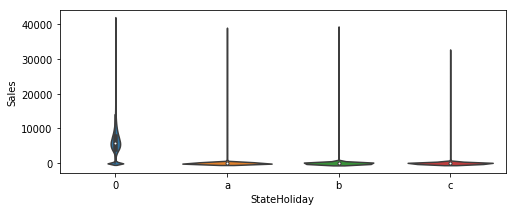

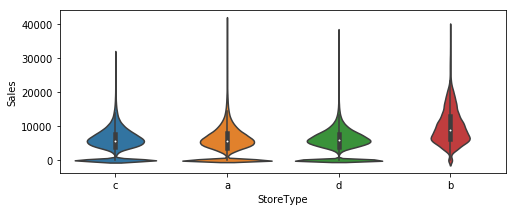

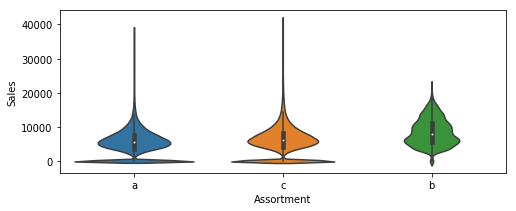

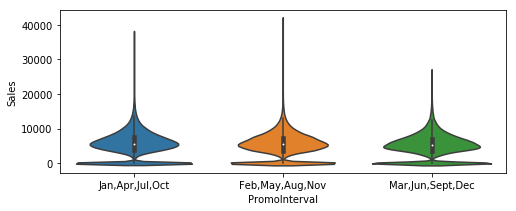

In [9]:
nondate_cate=['StateHoliday','StoreType','Assortment','PromoInterval']

for feature in nondate_cate:
    plt.figure(figsize=(8,3))
    sns.violinplot(x=data[feature],y=data.Sales)
    plt.show()

In [10]:
drop_labels=['Store','Open','StateHoliday','StoreType','Assortment','PromoInterval']
data_cor=data.drop(drop_labels,axis=1).corr()

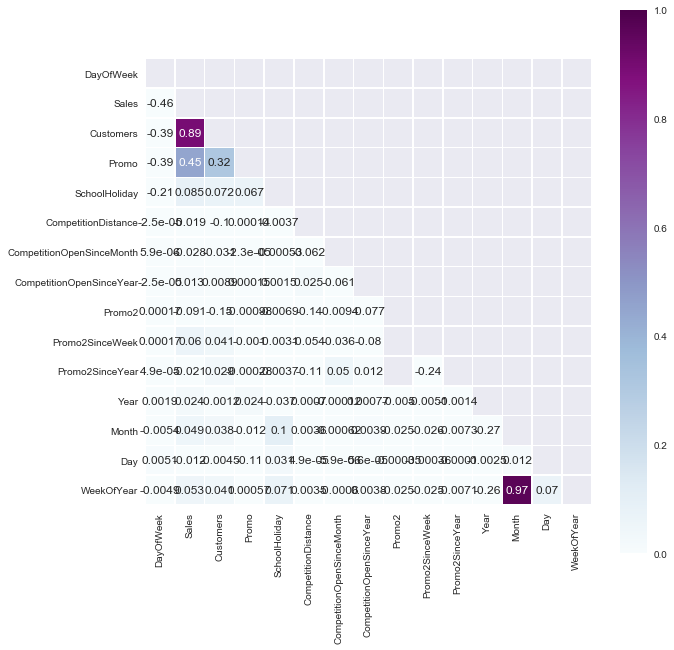

In [11]:
sns.set()
plt.figure(figsize=(10,10))
# Generate a mask for the upper triangle
mask = np.zeros_like(data_cor, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(data_cor,vmin=0,vmax=1, mask = mask,annot=True,
            square = True, linewidths = .5, cmap = "BuPu")  

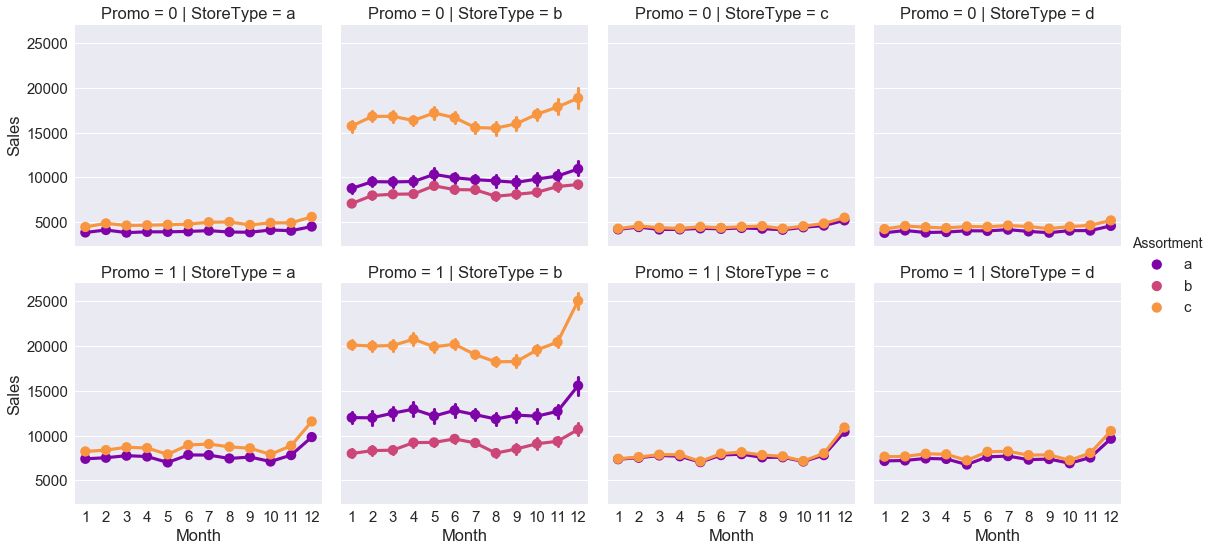

In [12]:
sns.set(font_scale=1.5)#set font size
sns.factorplot(data = data, x = 'Month', y = "Sales", 
               col_order=['a','b','c','d'],
               hue_order=['a','b','c'],
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'Assortment',
               row = 'Promo', # per promo in the store in rows
               ) 

## Data Preprocessing and feature engineering
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. There are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

In [13]:
data.fillna(0,inplace=True)
data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + \
(data.Month - data.CompetitionOpenSinceMonth)
data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + \
(data.WeekOfYear - data.Promo2SinceWeek) / 4.0

In [14]:
# feature selection to drop repeating columns
label_data = data['Sales'] # Seperate label from training dataset
droplabels=['Sales','Customers','PromoInterval','Date']
feature_data = data.drop(droplabels, axis = 1)

In [15]:
# log transformation of Sales
label_data.apply(lambda x: np.log(x + 1));



From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |



In [16]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(feature_data,columns=['StoreType','Assortment','StateHoliday'])


# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print ("{} total features after one-hot encoding.".format(len(encoded)))

# the encoded feature names
#print (encoded)

28 total features after one-hot encoding.


In [17]:
features_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 28 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
SchoolHoliday                1017209 non-null float64
CompetitionDistance          1017209 non-null float64
CompetitionOpenSinceMonth    1017209 non-null float64
CompetitionOpenSinceYear     1017209 non-null float64
Promo2                       1017209 non-null int64
Promo2SinceWeek              1017209 non-null float64
Promo2SinceYear              1017209 non-null float64
Year                         1017209 non-null int64
Month                        1017209 non-null int64
Day                          1017209 non-null int64
WeekOfYear                   1017209 non-null int64
CompetitionOpen              1017209 non-null float64
PromoOpen                    1017209 non-

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [18]:

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    label_data, 
                                                    test_size = 0.1, 
                                                    shuffle=False)
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)
# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 915488 samples.
Testing set has 101721 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

In [ ]:
# Evaluation Metric setup
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

In [19]:
def elapsed_time(f):
    def wrapper(*args,**kwargs):
        t1=time.time()
        f(*args,**kwargs)
        t2=time.time()
        print('Elapsed time:{0:.2f} ms,{1:.2f} mins'.format((t2-t1) * 1000,(t2 - t1) / 60))
    return wrapper

@elapsed_time
def pipeline(learner,X_train,y_train,X_test,y_test):
    regr = learner(random_state=42)
    regr.fit(X_train, y_train)
    rmspe=rmspe(y_test, np.expm1(regr.predict(X_test)))
    return print("For this algorithm, the score of RMSPE is {0:.2f}".format(rmspe)

In [20]:
pipeline(RandomForestRegressor,X_train,y_train,X_test,y_test)
pipeline(XGBRegressor,X_train,y_train,X_test,y_test)

For this algorithm, the percentage error of MSE is -735717547.06
Elapsed time:62297.34 ms,1.04 mins
For this algorithm, the percentage error of MSE is -645235441.21
Elapsed time:60078.23 ms,1.00 mins


----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

#### XGBoost key Parameters


- `learning_rate`: Step size used in updating weights. Lower value means slower training but better convergence. 
- `n_estimators`: Total number of iterations.
- `subsample`: The ratio of training data used in each iteration; combat overfitting. Should be configured in the range of 30% to 80% of the training dataset, and compared to a value of 100% for no sampling.
- `colsample_bytree`: The ratio of features used in each iteration, default 1.
- `max_depth`: The maximum depth of each tree. If we do not limit max depth, gradient boosting would eventually overfit.
- `early_stopping_rounds`: If there's no increase in validation score for a given number of iterations, the algorithm will stop early, also combats overfitting.
- `n_jobs`:Number of parallel threads used to run xgboost.

In [21]:
'''
The following three cells is referenced from one of the Kaggle kernels, 
and it is used for tuning parameters from clear visulization instead of randomly guessing. 
'''


def evaluate_param(clf,parameter, num_range, index):
    scorer = make_scorer(mean_squared_error)
    grid_search = GridSearchCV(clf, param_grid = {parameter: num_range}, scoring=scorer)
    try:
        grid_search.fit(X_train, np.ravel(y_train[:]),early_stopping_rounds=50)
    except:
        grid_search.fit(X_train, np.ravel(y_train[:]))
    
    df = {}
    
    for i, score in enumerate(grid_search.grid_scores_):
        df[score[0][parameter]] = score[1]
       
    
    df = pd.DataFrame.from_dict(df, orient='index')
    df.reset_index(level=0, inplace=True)
    df = df.sort_values(by='index')
 
    plt.subplot(3,2,index)
    plot = plt.plot(df['index'], df[0])
    plt.title(parameter)
    return plot, df

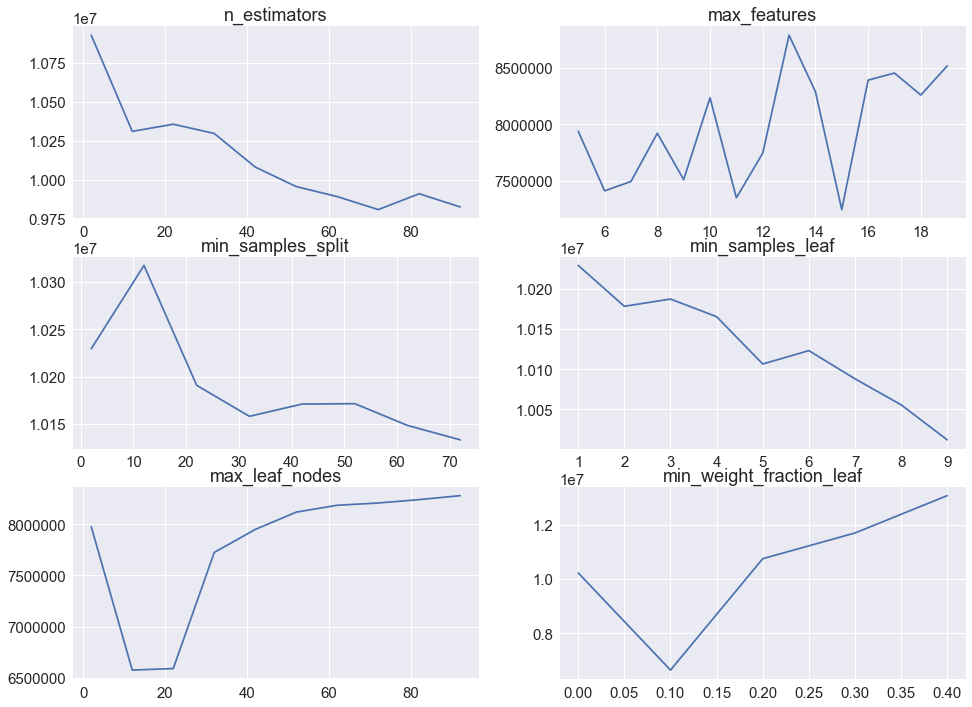

In [22]:
# set up random forest regressor parameters

# parameters visualization for narrow down numerical parameters to a certain range
# Max 6 sets of parameters
param_grid = {"n_estimators": np.arange(10, 100, 10),
              "max_features": np.arange(10, 16, 2),
              "min_samples_split": np.arange(2,80,10),
              "min_samples_leaf": np.arange(1,10,2),
              "max_leaf_nodes": np.arange(2,100,20),
              "min_weight_fraction_leaf": np.arange(0.0,0.5,0.1)}

index = 1

clf=RandomForestRegressor(random_state=42) #Initialize the regressor

plt.figure(figsize=(16,12))
for parameter, param_range in dict.items(param_grid):   
    evaluate_param(clf,parameter, param_range, index)
    index += 1

XGBoost parameters refer to this [link](http://xgboost.readthedocs.io/en/latest/parameter.html) and the xgboost scikit-learn API for python is this [link](http://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=xgboost%20sklearn#module-xgboost.sklearn)

## Redo the data preprocess

In [23]:
# Assume store open, if not provided
train.fillna(1, inplace=True)
test.fillna(1, inplace=True)

In [24]:
#Consider only open stores for training. Closed stores wont count into the score.
train = train[train["Open"] != 0]
#Use only Sales bigger then zero. Simplifies calculation of rmspe
train = train[train["Sales"] > 0]

In [25]:
# input extra features
train_data=pd.merge(train,store,on='Store',how='left')
test_data=pd.merge(test,store,on='Store',how='left')

In [26]:
# Gather some features referenced from Kaggle kernel


def build_features(features, data):
    # remove NaNs
    data.fillna(0, inplace=True)
    data.loc[data.Open.isnull(), 'Open'] = 1
    # Use some properties directly
    features.extend(['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday'])

    # Label encode some features
    features.extend(['StoreType', 'Assortment', 'StateHoliday'])
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)

    features.extend(['DayOfWeek', 'Month', 'Day', 'Year', 'WeekOfYear'])
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear
    # CompetionOpen en PromoOpen from https://www.kaggle.com/ananya77041/rossmann-store-sales/randomforestpython/code
    # Calculate time competition open time in months
    features.append('CompetitionOpen')
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + \
        (data.Month - data.CompetitionOpenSinceMonth)
    # Promo open time in months
    features.append('PromoOpen')
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + \
        (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    data.loc[data.Promo2SinceYear == 0, 'PromoOpen'] = 0

    # Indicate that sales on that day are in promo interval
    features.append('IsPromoMonth')
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1
    # Insert a feature to differ different zones from state holidays
    features.append('zone')
    for storeid in data.Store.unique():
        data.loc[(data.Store == storeid) & (data.StateHoliday == 0),'zone'] = 0
        zonenum=data.loc[(data.Store == storeid),'zone'].isnull().sum()
        # store the number to holidaycount feature
        data.loc[(data.Store == storeid)& (data.zone.isnull()),'zone'] = zonenum
    # alter the data type to a proper one
    altintfeatures=['SchoolHoliday','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear','zone']
    data[altintfeatures]=data[altintfeatures].astype(np.int64)    
    return data

In [27]:
features = []
build_features(features, train_data)
build_features([], test_data);

In [28]:
train_data.set_index('Date',inplace=True)
test_data.set_index('Date',inplace=True)
train_data.sort_index(ascending = True,inplace=True)

In [30]:
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.015,
          "max_depth": 16,
          "subsample": 0.8,
          "colsample_bytree": 0.7,
          "alpha":6,#L1 regularization term on weights, increase this value will make model more conservative.
          "tree_method":'hist',#default 'auto'
          "grow_policy":'lossguide',#default=’depthwise’
          "silent": 1,
          "seed": 42
          }

num_boost_round = 10000
early_stopping_rounds = 5000

In [31]:
X_train, X_valid = train_test_split(train_data, test_size=0.1,shuffle=False)
y_train = np.log1p(X_train.Sales)
y_valid = np.log1p(X_valid.Sales)

dtrain = xgb.DMatrix(X_train[features], y_train)
dvalid = xgb.DMatrix(X_valid[features], y_valid)

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

model_final = xgb.train(params, dtrain, num_boost_round, evals=watchlist, 
  early_stopping_rounds=early_stopping_rounds,feval=rmspe_xg, verbose_eval=True)

[0]	train-rmse:8.14036	eval-rmse:8.18655	train-rmspe:0.99985	eval-rmspe:0.999858
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 5000 rounds.
[1]	train-rmse:8.01853	eval-rmse:8.06476	train-rmspe:0.999808	eval-rmspe:0.999818
[2]	train-rmse:7.89855	eval-rmse:7.94458	train-rmspe:0.999762	eval-rmspe:0.999774
[3]	train-rmse:7.78033	eval-rmse:7.82656	train-rmspe:0.99971	eval-rmspe:0.999726
[4]	train-rmse:7.66392	eval-rmse:7.71005	train-rmspe:0.999654	eval-rmspe:0.999672
[5]	train-rmse:7.54926	eval-rmse:7.59533	train-rmspe:0.999591	eval-rmspe:0.999612
[6]	train-rmse:7.43633	eval-rmse:7.48213	train-rmspe:0.999521	eval-rmspe:0.999546
[7]	train-rmse:7.32505	eval-rmse:7.37106	train-rmspe:0.999445	eval-rmspe:0.999474
[8]	train-rmse:7.21548	eval-rmse:7.26125	train-rmspe:0.999361	eval-rmspe:0.999394
[9]	train-rmse:7.10752	eval-rmse:7.15346	train-rmspe:0.999268	eval-rmspe:0.999307
[10]	train-rmse:7.00118	eval-rmse:7

[98]	train-rmse:1.87753	eval-rmse:1.92493	train-rmspe:0.836503	eval-rmspe:0.844376
[99]	train-rmse:1.85015	eval-rmse:1.89741	train-rmspe:0.831993	eval-rmspe:0.840038
[100]	train-rmse:1.82317	eval-rmse:1.87043	train-rmspe:0.827441	eval-rmspe:0.835683
[101]	train-rmse:1.79662	eval-rmse:1.84392	train-rmspe:0.822835	eval-rmspe:0.831287
[102]	train-rmse:1.77022	eval-rmse:1.81735	train-rmspe:0.818266	eval-rmspe:0.826854
[103]	train-rmse:1.7443	eval-rmse:1.79131	train-rmspe:0.813624	eval-rmspe:0.822367
[104]	train-rmse:1.71894	eval-rmse:1.76592	train-rmspe:0.808887	eval-rmspe:0.817824
[105]	train-rmse:1.69398	eval-rmse:1.74089	train-rmspe:0.804099	eval-rmspe:0.813218
[106]	train-rmse:1.6691	eval-rmse:1.71591	train-rmspe:0.799367	eval-rmspe:0.80864
[107]	train-rmse:1.64488	eval-rmse:1.69172	train-rmspe:0.794507	eval-rmspe:0.80398
[108]	train-rmse:1.62101	eval-rmse:1.66775	train-rmspe:0.789613	eval-rmspe:0.799264
[109]	train-rmse:1.59739	eval-rmse:1.64403	train-rmspe:0.784725	eval-rmspe:0.79456

[195]	train-rmse:0.49637	eval-rmse:0.534559	train-rmspe:0.384007	eval-rmspe:0.392889
[196]	train-rmse:0.490755	eval-rmse:0.5287	train-rmspe:0.380968	eval-rmspe:0.389489
[197]	train-rmse:0.485153	eval-rmse:0.523011	train-rmspe:0.377937	eval-rmspe:0.386191
[198]	train-rmse:0.479267	eval-rmse:0.517043	train-rmspe:0.374836	eval-rmspe:0.382826
[199]	train-rmse:0.473751	eval-rmse:0.51133	train-rmspe:0.371823	eval-rmspe:0.379502
[200]	train-rmse:0.468386	eval-rmse:0.505841	train-rmspe:0.368949	eval-rmspe:0.376271
[201]	train-rmse:0.462992	eval-rmse:0.500353	train-rmspe:0.366019	eval-rmspe:0.373063
[202]	train-rmse:0.457865	eval-rmse:0.49522	train-rmspe:0.363216	eval-rmspe:0.370036
[203]	train-rmse:0.452585	eval-rmse:0.489861	train-rmspe:0.360272	eval-rmspe:0.366893
[204]	train-rmse:0.447687	eval-rmse:0.484757	train-rmspe:0.357607	eval-rmspe:0.363844
[205]	train-rmse:0.442765	eval-rmse:0.47976	train-rmspe:0.354916	eval-rmspe:0.360884
[206]	train-rmse:0.438028	eval-rmse:0.474919	train-rmspe:0.3

[291]	train-rmse:0.226235	eval-rmse:0.25767	train-rmspe:0.245834	eval-rmspe:0.226887
[292]	train-rmse:0.225038	eval-rmse:0.256521	train-rmspe:0.2453	eval-rmspe:0.226152
[293]	train-rmse:0.223864	eval-rmse:0.255401	train-rmspe:0.24479	eval-rmspe:0.225438
[294]	train-rmse:0.222429	eval-rmse:0.253965	train-rmspe:0.244003	eval-rmspe:0.224537
[295]	train-rmse:0.221376	eval-rmse:0.253082	train-rmspe:0.243598	eval-rmspe:0.224063
[296]	train-rmse:0.2202	eval-rmse:0.25193	train-rmspe:0.242991	eval-rmspe:0.223349
[297]	train-rmse:0.219397	eval-rmse:0.251085	train-rmspe:0.242699	eval-rmspe:0.222966
[298]	train-rmse:0.2187	eval-rmse:0.250328	train-rmspe:0.242509	eval-rmspe:0.222664
[299]	train-rmse:0.217795	eval-rmse:0.249373	train-rmspe:0.242164	eval-rmspe:0.222092
[300]	train-rmse:0.216916	eval-rmse:0.248537	train-rmspe:0.241762	eval-rmspe:0.22172
[301]	train-rmse:0.216034	eval-rmse:0.247751	train-rmspe:0.241443	eval-rmspe:0.221361
[302]	train-rmse:0.214906	eval-rmse:0.246586	train-rmspe:0.24088

[387]	train-rmse:0.163476	eval-rmse:0.198038	train-rmspe:0.215737	eval-rmspe:0.192111
[388]	train-rmse:0.162913	eval-rmse:0.197569	train-rmspe:0.215374	eval-rmspe:0.191758
[389]	train-rmse:0.162608	eval-rmse:0.197442	train-rmspe:0.21521	eval-rmspe:0.191742
[390]	train-rmse:0.162148	eval-rmse:0.197015	train-rmspe:0.214933	eval-rmspe:0.191406
[391]	train-rmse:0.162004	eval-rmse:0.196891	train-rmspe:0.214878	eval-rmspe:0.191384
[392]	train-rmse:0.161446	eval-rmse:0.196369	train-rmspe:0.21451	eval-rmspe:0.190984
[393]	train-rmse:0.161152	eval-rmse:0.196106	train-rmspe:0.2143	eval-rmspe:0.190828
[394]	train-rmse:0.1606	eval-rmse:0.195652	train-rmspe:0.213914	eval-rmspe:0.190506
[395]	train-rmse:0.160459	eval-rmse:0.195506	train-rmspe:0.213856	eval-rmspe:0.190479
[396]	train-rmse:0.160124	eval-rmse:0.195178	train-rmspe:0.213613	eval-rmspe:0.190234
[397]	train-rmse:0.159911	eval-rmse:0.194995	train-rmspe:0.213396	eval-rmspe:0.190152
[398]	train-rmse:0.159755	eval-rmse:0.194878	train-rmspe:0.2

[483]	train-rmse:0.138662	eval-rmse:0.176792	train-rmspe:0.198474	eval-rmspe:0.176739
[484]	train-rmse:0.138596	eval-rmse:0.176765	train-rmspe:0.198416	eval-rmspe:0.176738
[485]	train-rmse:0.138388	eval-rmse:0.176568	train-rmspe:0.198264	eval-rmspe:0.176567
[486]	train-rmse:0.138135	eval-rmse:0.176325	train-rmspe:0.198085	eval-rmspe:0.176345
[487]	train-rmse:0.137883	eval-rmse:0.17607	train-rmspe:0.197923	eval-rmspe:0.17612
[488]	train-rmse:0.137803	eval-rmse:0.17606	train-rmspe:0.197868	eval-rmspe:0.176148
[489]	train-rmse:0.137651	eval-rmse:0.175934	train-rmspe:0.197809	eval-rmspe:0.176046
[490]	train-rmse:0.137527	eval-rmse:0.175816	train-rmspe:0.197681	eval-rmspe:0.175954
[491]	train-rmse:0.13723	eval-rmse:0.175549	train-rmspe:0.197527	eval-rmspe:0.175725
[492]	train-rmse:0.137159	eval-rmse:0.175564	train-rmspe:0.197432	eval-rmspe:0.17577
[493]	train-rmse:0.137025	eval-rmse:0.175436	train-rmspe:0.197302	eval-rmspe:0.175654
[494]	train-rmse:0.136965	eval-rmse:0.175354	train-rmspe:0.

[579]	train-rmse:0.124453	eval-rmse:0.164657	train-rmspe:0.187388	eval-rmspe:0.166017
[580]	train-rmse:0.1243	eval-rmse:0.164518	train-rmspe:0.18729	eval-rmspe:0.165885
[581]	train-rmse:0.124145	eval-rmse:0.164371	train-rmspe:0.18714	eval-rmspe:0.165744
[582]	train-rmse:0.124098	eval-rmse:0.164373	train-rmspe:0.187093	eval-rmspe:0.165756
[583]	train-rmse:0.12404	eval-rmse:0.164343	train-rmspe:0.187022	eval-rmspe:0.165738
[584]	train-rmse:0.123935	eval-rmse:0.164243	train-rmspe:0.186925	eval-rmspe:0.165639
[585]	train-rmse:0.123791	eval-rmse:0.16408	train-rmspe:0.186779	eval-rmspe:0.165475
[586]	train-rmse:0.123731	eval-rmse:0.164008	train-rmspe:0.186707	eval-rmspe:0.165412
[587]	train-rmse:0.123672	eval-rmse:0.163982	train-rmspe:0.186677	eval-rmspe:0.165388
[588]	train-rmse:0.123554	eval-rmse:0.163886	train-rmspe:0.186664	eval-rmspe:0.165294
[589]	train-rmse:0.123483	eval-rmse:0.163831	train-rmspe:0.186597	eval-rmspe:0.165243
[590]	train-rmse:0.123402	eval-rmse:0.163768	train-rmspe:0.1

[675]	train-rmse:0.116097	eval-rmse:0.157652	train-rmspe:0.180482	eval-rmspe:0.159432
[676]	train-rmse:0.116064	eval-rmse:0.15764	train-rmspe:0.180444	eval-rmspe:0.159419
[677]	train-rmse:0.115977	eval-rmse:0.157559	train-rmspe:0.180373	eval-rmspe:0.159338
[678]	train-rmse:0.115936	eval-rmse:0.157545	train-rmspe:0.180305	eval-rmspe:0.159324
[679]	train-rmse:0.115862	eval-rmse:0.157509	train-rmspe:0.18025	eval-rmspe:0.159292
[680]	train-rmse:0.11572	eval-rmse:0.157376	train-rmspe:0.18014	eval-rmspe:0.159168
[681]	train-rmse:0.115669	eval-rmse:0.157324	train-rmspe:0.180105	eval-rmspe:0.159111
[682]	train-rmse:0.115644	eval-rmse:0.15734	train-rmspe:0.180078	eval-rmspe:0.159144
[683]	train-rmse:0.115544	eval-rmse:0.157239	train-rmspe:0.18	eval-rmspe:0.159041
[684]	train-rmse:0.115412	eval-rmse:0.157125	train-rmspe:0.179902	eval-rmspe:0.158928
[685]	train-rmse:0.115325	eval-rmse:0.157031	train-rmspe:0.179824	eval-rmspe:0.15883
[686]	train-rmse:0.115258	eval-rmse:0.156953	train-rmspe:0.17978

[771]	train-rmse:0.110537	eval-rmse:0.153096	train-rmspe:0.175936	eval-rmspe:0.154973
[772]	train-rmse:0.110451	eval-rmse:0.15301	train-rmspe:0.175877	eval-rmspe:0.154879
[773]	train-rmse:0.110417	eval-rmse:0.152986	train-rmspe:0.17583	eval-rmspe:0.154855
[774]	train-rmse:0.110351	eval-rmse:0.152913	train-rmspe:0.175792	eval-rmspe:0.15478
[775]	train-rmse:0.110301	eval-rmse:0.152869	train-rmspe:0.175757	eval-rmspe:0.154733
[776]	train-rmse:0.110268	eval-rmse:0.152834	train-rmspe:0.175734	eval-rmspe:0.154698
[777]	train-rmse:0.110241	eval-rmse:0.152816	train-rmspe:0.175717	eval-rmspe:0.154677
[778]	train-rmse:0.110183	eval-rmse:0.15276	train-rmspe:0.175683	eval-rmspe:0.154623
[779]	train-rmse:0.110154	eval-rmse:0.152751	train-rmspe:0.175659	eval-rmspe:0.154614
[780]	train-rmse:0.110129	eval-rmse:0.152759	train-rmspe:0.175621	eval-rmspe:0.154652
[781]	train-rmse:0.110107	eval-rmse:0.152733	train-rmspe:0.175604	eval-rmspe:0.154623
[782]	train-rmse:0.110075	eval-rmse:0.152719	train-rmspe:0

[867]	train-rmse:0.106382	eval-rmse:0.149808	train-rmspe:0.17219	eval-rmspe:0.151647
[868]	train-rmse:0.106338	eval-rmse:0.149769	train-rmspe:0.172154	eval-rmspe:0.151606
[869]	train-rmse:0.10632	eval-rmse:0.149771	train-rmspe:0.172172	eval-rmspe:0.151609
[870]	train-rmse:0.106267	eval-rmse:0.149719	train-rmspe:0.172123	eval-rmspe:0.151556
[871]	train-rmse:0.106195	eval-rmse:0.14966	train-rmspe:0.172062	eval-rmspe:0.151495
[872]	train-rmse:0.106155	eval-rmse:0.149614	train-rmspe:0.172037	eval-rmspe:0.151448
[873]	train-rmse:0.106085	eval-rmse:0.149563	train-rmspe:0.171976	eval-rmspe:0.151397
[874]	train-rmse:0.106054	eval-rmse:0.149542	train-rmspe:0.171964	eval-rmspe:0.151378
[875]	train-rmse:0.106005	eval-rmse:0.14949	train-rmspe:0.171932	eval-rmspe:0.151327
[876]	train-rmse:0.105978	eval-rmse:0.149498	train-rmspe:0.171893	eval-rmspe:0.151337
[877]	train-rmse:0.105913	eval-rmse:0.14945	train-rmspe:0.17184	eval-rmspe:0.15129
[878]	train-rmse:0.105882	eval-rmse:0.149421	train-rmspe:0.17

[963]	train-rmse:0.10322	eval-rmse:0.147255	train-rmspe:0.169168	eval-rmspe:0.14907
[964]	train-rmse:0.103212	eval-rmse:0.147249	train-rmspe:0.169151	eval-rmspe:0.149065
[965]	train-rmse:0.103187	eval-rmse:0.147232	train-rmspe:0.169113	eval-rmspe:0.14905
[966]	train-rmse:0.103175	eval-rmse:0.147231	train-rmspe:0.169097	eval-rmspe:0.14905
[967]	train-rmse:0.103152	eval-rmse:0.147201	train-rmspe:0.169074	eval-rmspe:0.149022
[968]	train-rmse:0.103147	eval-rmse:0.147194	train-rmspe:0.169069	eval-rmspe:0.149017
[969]	train-rmse:0.103116	eval-rmse:0.147162	train-rmspe:0.169038	eval-rmspe:0.148987
[970]	train-rmse:0.103096	eval-rmse:0.14714	train-rmspe:0.169022	eval-rmspe:0.148965
[971]	train-rmse:0.103086	eval-rmse:0.147141	train-rmspe:0.169005	eval-rmspe:0.148966
[972]	train-rmse:0.103052	eval-rmse:0.147107	train-rmspe:0.168977	eval-rmspe:0.148929
[973]	train-rmse:0.103039	eval-rmse:0.147105	train-rmspe:0.168961	eval-rmspe:0.148925
[974]	train-rmse:0.10303	eval-rmse:0.147104	train-rmspe:0.1

[1059]	train-rmse:0.100905	eval-rmse:0.145479	train-rmspe:0.166912	eval-rmspe:0.147254
[1060]	train-rmse:0.10087	eval-rmse:0.145449	train-rmspe:0.16685	eval-rmspe:0.147224
[1061]	train-rmse:0.100862	eval-rmse:0.145445	train-rmspe:0.166838	eval-rmspe:0.147221
[1062]	train-rmse:0.10085	eval-rmse:0.14544	train-rmspe:0.166786	eval-rmspe:0.147217
[1063]	train-rmse:0.100838	eval-rmse:0.145446	train-rmspe:0.166769	eval-rmspe:0.147209
[1064]	train-rmse:0.100821	eval-rmse:0.145444	train-rmspe:0.166753	eval-rmspe:0.147206
[1065]	train-rmse:0.100806	eval-rmse:0.14543	train-rmspe:0.166742	eval-rmspe:0.147192
[1066]	train-rmse:0.100788	eval-rmse:0.145414	train-rmspe:0.166707	eval-rmspe:0.147177
[1067]	train-rmse:0.100747	eval-rmse:0.145375	train-rmspe:0.166702	eval-rmspe:0.147136
[1068]	train-rmse:0.100734	eval-rmse:0.145369	train-rmspe:0.166623	eval-rmspe:0.147132
[1069]	train-rmse:0.100718	eval-rmse:0.145366	train-rmspe:0.16661	eval-rmspe:0.147129
[1070]	train-rmse:0.1007	eval-rmse:0.145373	train

[1154]	train-rmse:0.099149	eval-rmse:0.144233	train-rmspe:0.164983	eval-rmspe:0.145971
[1155]	train-rmse:0.099113	eval-rmse:0.144194	train-rmspe:0.164954	eval-rmspe:0.145929
[1156]	train-rmse:0.099103	eval-rmse:0.144193	train-rmspe:0.164939	eval-rmspe:0.145929
[1157]	train-rmse:0.099096	eval-rmse:0.144193	train-rmspe:0.164912	eval-rmspe:0.145928
[1158]	train-rmse:0.099072	eval-rmse:0.144177	train-rmspe:0.164893	eval-rmspe:0.145912
[1159]	train-rmse:0.099059	eval-rmse:0.144164	train-rmspe:0.164883	eval-rmspe:0.1459
[1160]	train-rmse:0.099046	eval-rmse:0.144149	train-rmspe:0.164856	eval-rmspe:0.145885
[1161]	train-rmse:0.099036	eval-rmse:0.144153	train-rmspe:0.164824	eval-rmspe:0.145889
[1162]	train-rmse:0.099017	eval-rmse:0.144143	train-rmspe:0.164808	eval-rmspe:0.145879
[1163]	train-rmse:0.098979	eval-rmse:0.144107	train-rmspe:0.164764	eval-rmspe:0.145842
[1164]	train-rmse:0.098965	eval-rmse:0.144111	train-rmspe:0.164739	eval-rmspe:0.145844
[1165]	train-rmse:0.098952	eval-rmse:0.144096

[1249]	train-rmse:0.097584	eval-rmse:0.143121	train-rmspe:0.163175	eval-rmspe:0.144823
[1250]	train-rmse:0.097573	eval-rmse:0.143113	train-rmspe:0.163167	eval-rmspe:0.144814
[1251]	train-rmse:0.097536	eval-rmse:0.143076	train-rmspe:0.163126	eval-rmspe:0.144775
[1252]	train-rmse:0.097526	eval-rmse:0.143067	train-rmspe:0.163111	eval-rmspe:0.144765
[1253]	train-rmse:0.097518	eval-rmse:0.143062	train-rmspe:0.163097	eval-rmspe:0.144762
[1254]	train-rmse:0.097499	eval-rmse:0.143052	train-rmspe:0.163073	eval-rmspe:0.144748
[1255]	train-rmse:0.097493	eval-rmse:0.143055	train-rmspe:0.163059	eval-rmspe:0.144754
[1256]	train-rmse:0.097484	eval-rmse:0.143042	train-rmspe:0.163039	eval-rmspe:0.144741
[1257]	train-rmse:0.097473	eval-rmse:0.143035	train-rmspe:0.163003	eval-rmspe:0.144735
[1258]	train-rmse:0.097465	eval-rmse:0.143039	train-rmspe:0.162988	eval-rmspe:0.144753
[1259]	train-rmse:0.097433	eval-rmse:0.143005	train-rmspe:0.162963	eval-rmspe:0.144715
[1260]	train-rmse:0.097424	eval-rmse:0.1430

[1344]	train-rmse:0.09641	eval-rmse:0.142378	train-rmspe:0.16156	eval-rmspe:0.144099
[1345]	train-rmse:0.096394	eval-rmse:0.14236	train-rmspe:0.16153	eval-rmspe:0.144083
[1346]	train-rmse:0.096385	eval-rmse:0.142359	train-rmspe:0.16151	eval-rmspe:0.144082
[1347]	train-rmse:0.096371	eval-rmse:0.142343	train-rmspe:0.161497	eval-rmspe:0.144069
[1348]	train-rmse:0.096351	eval-rmse:0.142331	train-rmspe:0.161483	eval-rmspe:0.144056
[1349]	train-rmse:0.096346	eval-rmse:0.142327	train-rmspe:0.161479	eval-rmspe:0.144053
[1350]	train-rmse:0.09634	eval-rmse:0.142326	train-rmspe:0.161451	eval-rmspe:0.144051
[1351]	train-rmse:0.096333	eval-rmse:0.142324	train-rmspe:0.161429	eval-rmspe:0.144047
[1352]	train-rmse:0.096314	eval-rmse:0.142308	train-rmspe:0.161403	eval-rmspe:0.144031
[1353]	train-rmse:0.096306	eval-rmse:0.142305	train-rmspe:0.161383	eval-rmspe:0.144028
[1354]	train-rmse:0.09629	eval-rmse:0.142287	train-rmspe:0.161368	eval-rmspe:0.144008
[1355]	train-rmse:0.096277	eval-rmse:0.142286	trai

[1439]	train-rmse:0.095403	eval-rmse:0.141689	train-rmspe:0.160218	eval-rmspe:0.143424
[1440]	train-rmse:0.095393	eval-rmse:0.141685	train-rmspe:0.160209	eval-rmspe:0.143421
[1441]	train-rmse:0.095388	eval-rmse:0.141683	train-rmspe:0.160205	eval-rmspe:0.143419
[1442]	train-rmse:0.095383	eval-rmse:0.141676	train-rmspe:0.160202	eval-rmspe:0.143411
[1443]	train-rmse:0.095373	eval-rmse:0.141666	train-rmspe:0.160198	eval-rmspe:0.143403
[1444]	train-rmse:0.095362	eval-rmse:0.141665	train-rmspe:0.160185	eval-rmspe:0.143402
[1445]	train-rmse:0.095355	eval-rmse:0.141655	train-rmspe:0.160178	eval-rmspe:0.143391
[1446]	train-rmse:0.095348	eval-rmse:0.141652	train-rmspe:0.160165	eval-rmspe:0.143383
[1447]	train-rmse:0.095344	eval-rmse:0.141649	train-rmspe:0.160162	eval-rmspe:0.14338
[1448]	train-rmse:0.095336	eval-rmse:0.141643	train-rmspe:0.160151	eval-rmspe:0.143378
[1449]	train-rmse:0.095329	eval-rmse:0.141648	train-rmspe:0.160148	eval-rmspe:0.143381
[1450]	train-rmse:0.095317	eval-rmse:0.14164

[1534]	train-rmse:0.094571	eval-rmse:0.141167	train-rmspe:0.158984	eval-rmspe:0.142906
[1535]	train-rmse:0.094565	eval-rmse:0.141162	train-rmspe:0.158986	eval-rmspe:0.142901
[1536]	train-rmse:0.094554	eval-rmse:0.141149	train-rmspe:0.158972	eval-rmspe:0.142888
[1537]	train-rmse:0.09455	eval-rmse:0.141151	train-rmspe:0.158959	eval-rmspe:0.142891
[1538]	train-rmse:0.09452	eval-rmse:0.141126	train-rmspe:0.158913	eval-rmspe:0.142863
[1539]	train-rmse:0.094512	eval-rmse:0.14112	train-rmspe:0.158904	eval-rmspe:0.142857
[1540]	train-rmse:0.094508	eval-rmse:0.141113	train-rmspe:0.158895	eval-rmspe:0.14285
[1541]	train-rmse:0.094496	eval-rmse:0.141102	train-rmspe:0.158888	eval-rmspe:0.142838
[1542]	train-rmse:0.094491	eval-rmse:0.141099	train-rmspe:0.158866	eval-rmspe:0.142838
[1543]	train-rmse:0.094482	eval-rmse:0.141087	train-rmspe:0.158848	eval-rmspe:0.142829
[1544]	train-rmse:0.094475	eval-rmse:0.141085	train-rmspe:0.158838	eval-rmspe:0.142827
[1545]	train-rmse:0.094472	eval-rmse:0.141083	t

[1629]	train-rmse:0.093817	eval-rmse:0.140669	train-rmspe:0.157752	eval-rmspe:0.142409
[1630]	train-rmse:0.093799	eval-rmse:0.140655	train-rmspe:0.15776	eval-rmspe:0.142395
[1631]	train-rmse:0.093793	eval-rmse:0.140653	train-rmspe:0.157756	eval-rmspe:0.142392
[1632]	train-rmse:0.09378	eval-rmse:0.14064	train-rmspe:0.1577	eval-rmspe:0.142379
[1633]	train-rmse:0.093773	eval-rmse:0.140635	train-rmspe:0.157703	eval-rmspe:0.142373
[1634]	train-rmse:0.093767	eval-rmse:0.140633	train-rmspe:0.157687	eval-rmspe:0.142372
[1635]	train-rmse:0.093761	eval-rmse:0.140637	train-rmspe:0.15768	eval-rmspe:0.142375
[1636]	train-rmse:0.093752	eval-rmse:0.14063	train-rmspe:0.157653	eval-rmspe:0.142369
[1637]	train-rmse:0.093747	eval-rmse:0.140637	train-rmspe:0.157644	eval-rmspe:0.142375
[1638]	train-rmse:0.093741	eval-rmse:0.140636	train-rmspe:0.15763	eval-rmspe:0.142373
[1639]	train-rmse:0.093726	eval-rmse:0.140621	train-rmspe:0.157626	eval-rmspe:0.142354
[1640]	train-rmse:0.093719	eval-rmse:0.140616	train

[1724]	train-rmse:0.093109	eval-rmse:0.140227	train-rmspe:0.156649	eval-rmspe:0.141969
[1725]	train-rmse:0.093103	eval-rmse:0.14023	train-rmspe:0.156624	eval-rmspe:0.141972
[1726]	train-rmse:0.0931	eval-rmse:0.140229	train-rmspe:0.156612	eval-rmspe:0.141971
[1727]	train-rmse:0.093093	eval-rmse:0.14022	train-rmspe:0.156601	eval-rmspe:0.141964
[1728]	train-rmse:0.093088	eval-rmse:0.140217	train-rmspe:0.156595	eval-rmspe:0.141959
[1729]	train-rmse:0.093084	eval-rmse:0.140216	train-rmspe:0.15658	eval-rmspe:0.141959
[1730]	train-rmse:0.093079	eval-rmse:0.140212	train-rmspe:0.15657	eval-rmspe:0.141957
[1731]	train-rmse:0.093073	eval-rmse:0.140204	train-rmspe:0.156565	eval-rmspe:0.141948
[1732]	train-rmse:0.093067	eval-rmse:0.140201	train-rmspe:0.156546	eval-rmspe:0.141945
[1733]	train-rmse:0.093059	eval-rmse:0.140194	train-rmspe:0.156534	eval-rmspe:0.141939
[1734]	train-rmse:0.093057	eval-rmse:0.140192	train-rmspe:0.156532	eval-rmspe:0.141938
[1735]	train-rmse:0.093041	eval-rmse:0.14018	trai

[1819]	train-rmse:0.092516	eval-rmse:0.139868	train-rmspe:0.155493	eval-rmspe:0.141625
[1820]	train-rmse:0.092511	eval-rmse:0.139867	train-rmspe:0.155487	eval-rmspe:0.141623
[1821]	train-rmse:0.092505	eval-rmse:0.139863	train-rmspe:0.155473	eval-rmspe:0.141619
[1822]	train-rmse:0.092502	eval-rmse:0.139864	train-rmspe:0.15547	eval-rmspe:0.141618
[1823]	train-rmse:0.0925	eval-rmse:0.139863	train-rmspe:0.155468	eval-rmspe:0.141618
[1824]	train-rmse:0.092494	eval-rmse:0.139858	train-rmspe:0.155464	eval-rmspe:0.141613
[1825]	train-rmse:0.092491	eval-rmse:0.139857	train-rmspe:0.155446	eval-rmspe:0.141612
[1826]	train-rmse:0.092486	eval-rmse:0.139859	train-rmspe:0.155433	eval-rmspe:0.141616
[1827]	train-rmse:0.09248	eval-rmse:0.139855	train-rmspe:0.155427	eval-rmspe:0.141613
[1828]	train-rmse:0.092478	eval-rmse:0.139854	train-rmspe:0.15542	eval-rmspe:0.141613
[1829]	train-rmse:0.092475	eval-rmse:0.139855	train-rmspe:0.155413	eval-rmspe:0.141612
[1830]	train-rmse:0.092467	eval-rmse:0.139848	tr

[1914]	train-rmse:0.091965	eval-rmse:0.139572	train-rmspe:0.154589	eval-rmspe:0.141348
[1915]	train-rmse:0.09196	eval-rmse:0.139569	train-rmspe:0.154592	eval-rmspe:0.141346
[1916]	train-rmse:0.091957	eval-rmse:0.139569	train-rmspe:0.154579	eval-rmspe:0.141345
[1917]	train-rmse:0.091953	eval-rmse:0.13957	train-rmspe:0.154571	eval-rmspe:0.141346
[1918]	train-rmse:0.091949	eval-rmse:0.139572	train-rmspe:0.154565	eval-rmspe:0.141346
[1919]	train-rmse:0.091946	eval-rmse:0.139576	train-rmspe:0.154562	eval-rmspe:0.141353
[1920]	train-rmse:0.09194	eval-rmse:0.139573	train-rmspe:0.154558	eval-rmspe:0.141349
[1921]	train-rmse:0.091932	eval-rmse:0.139565	train-rmspe:0.154535	eval-rmspe:0.14134
[1922]	train-rmse:0.091925	eval-rmse:0.13956	train-rmspe:0.154476	eval-rmspe:0.141335
[1923]	train-rmse:0.091923	eval-rmse:0.13956	train-rmspe:0.154472	eval-rmspe:0.141338
[1924]	train-rmse:0.091917	eval-rmse:0.13956	train-rmspe:0.154454	eval-rmspe:0.141337
[1925]	train-rmse:0.091907	eval-rmse:0.139552	trai

[2009]	train-rmse:0.091426	eval-rmse:0.13927	train-rmspe:0.15373	eval-rmspe:0.141045
[2010]	train-rmse:0.091421	eval-rmse:0.139266	train-rmspe:0.153719	eval-rmspe:0.141043
[2011]	train-rmse:0.091417	eval-rmse:0.139263	train-rmspe:0.153714	eval-rmspe:0.141042
[2012]	train-rmse:0.091414	eval-rmse:0.139266	train-rmspe:0.153705	eval-rmspe:0.141044
[2013]	train-rmse:0.091409	eval-rmse:0.139261	train-rmspe:0.153692	eval-rmspe:0.141038
[2014]	train-rmse:0.091403	eval-rmse:0.13926	train-rmspe:0.153686	eval-rmspe:0.141039
[2015]	train-rmse:0.091397	eval-rmse:0.139253	train-rmspe:0.153686	eval-rmspe:0.141032
[2016]	train-rmse:0.091393	eval-rmse:0.139254	train-rmspe:0.15368	eval-rmspe:0.141033
[2017]	train-rmse:0.091385	eval-rmse:0.13925	train-rmspe:0.153659	eval-rmspe:0.141029
[2018]	train-rmse:0.091382	eval-rmse:0.139248	train-rmspe:0.153655	eval-rmspe:0.141027
[2019]	train-rmse:0.091379	eval-rmse:0.139247	train-rmspe:0.15363	eval-rmspe:0.141026
[2020]	train-rmse:0.091372	eval-rmse:0.139241	tra

[2104]	train-rmse:0.090958	eval-rmse:0.139001	train-rmspe:0.152651	eval-rmspe:0.140788
[2105]	train-rmse:0.090954	eval-rmse:0.138999	train-rmspe:0.152642	eval-rmspe:0.140787
[2106]	train-rmse:0.090951	eval-rmse:0.138998	train-rmspe:0.152631	eval-rmspe:0.140785
[2107]	train-rmse:0.090943	eval-rmse:0.138994	train-rmspe:0.152605	eval-rmspe:0.140781
[2108]	train-rmse:0.090939	eval-rmse:0.138992	train-rmspe:0.15259	eval-rmspe:0.14078
[2109]	train-rmse:0.090934	eval-rmse:0.13899	train-rmspe:0.152596	eval-rmspe:0.140778
[2110]	train-rmse:0.09093	eval-rmse:0.13899	train-rmspe:0.152586	eval-rmspe:0.140779
[2111]	train-rmse:0.090926	eval-rmse:0.138991	train-rmspe:0.152576	eval-rmspe:0.140781
[2112]	train-rmse:0.090921	eval-rmse:0.138989	train-rmspe:0.15257	eval-rmspe:0.14078
[2113]	train-rmse:0.090918	eval-rmse:0.138989	train-rmspe:0.152557	eval-rmspe:0.140779
[2114]	train-rmse:0.090914	eval-rmse:0.138987	train-rmspe:0.152541	eval-rmspe:0.140777
[2115]	train-rmse:0.09091	eval-rmse:0.138985	train

[2199]	train-rmse:0.090503	eval-rmse:0.138803	train-rmspe:0.151878	eval-rmspe:0.140603
[2200]	train-rmse:0.0905	eval-rmse:0.138802	train-rmspe:0.151865	eval-rmspe:0.140601
[2201]	train-rmse:0.090497	eval-rmse:0.138802	train-rmspe:0.151858	eval-rmspe:0.140601
[2202]	train-rmse:0.090495	eval-rmse:0.138802	train-rmspe:0.151853	eval-rmspe:0.140601
[2203]	train-rmse:0.090489	eval-rmse:0.1388	train-rmspe:0.151848	eval-rmspe:0.140597
[2204]	train-rmse:0.090485	eval-rmse:0.138797	train-rmspe:0.151843	eval-rmspe:0.140594
[2205]	train-rmse:0.090475	eval-rmse:0.138791	train-rmspe:0.151834	eval-rmspe:0.140587
[2206]	train-rmse:0.090473	eval-rmse:0.138791	train-rmspe:0.151836	eval-rmspe:0.140587
[2207]	train-rmse:0.09047	eval-rmse:0.138795	train-rmspe:0.151834	eval-rmspe:0.140588
[2208]	train-rmse:0.090467	eval-rmse:0.138793	train-rmspe:0.151824	eval-rmspe:0.140588
[2209]	train-rmse:0.090464	eval-rmse:0.138791	train-rmspe:0.151821	eval-rmspe:0.140587
[2210]	train-rmse:0.090462	eval-rmse:0.13879	tra

[2294]	train-rmse:0.090112	eval-rmse:0.138622	train-rmspe:0.151176	eval-rmspe:0.140427
[2295]	train-rmse:0.090107	eval-rmse:0.138619	train-rmspe:0.151167	eval-rmspe:0.140422
[2296]	train-rmse:0.090103	eval-rmse:0.138616	train-rmspe:0.151162	eval-rmspe:0.140419
[2297]	train-rmse:0.090095	eval-rmse:0.138608	train-rmspe:0.151153	eval-rmspe:0.14041
[2298]	train-rmse:0.090091	eval-rmse:0.138604	train-rmspe:0.151147	eval-rmspe:0.140406
[2299]	train-rmse:0.090087	eval-rmse:0.138603	train-rmspe:0.151132	eval-rmspe:0.140406
[2300]	train-rmse:0.090084	eval-rmse:0.138602	train-rmspe:0.151117	eval-rmspe:0.140404
[2301]	train-rmse:0.090081	eval-rmse:0.138601	train-rmspe:0.15111	eval-rmspe:0.140404
[2302]	train-rmse:0.090079	eval-rmse:0.138601	train-rmspe:0.151108	eval-rmspe:0.140405
[2303]	train-rmse:0.090073	eval-rmse:0.138596	train-rmspe:0.151092	eval-rmspe:0.1404
[2304]	train-rmse:0.090069	eval-rmse:0.138595	train-rmspe:0.151085	eval-rmspe:0.1404
[2305]	train-rmse:0.090063	eval-rmse:0.138593	tra

[2389]	train-rmse:0.089769	eval-rmse:0.13846	train-rmspe:0.150412	eval-rmspe:0.140271
[2390]	train-rmse:0.089766	eval-rmse:0.138459	train-rmspe:0.150404	eval-rmspe:0.140271
[2391]	train-rmse:0.089763	eval-rmse:0.138459	train-rmspe:0.150371	eval-rmspe:0.14027
[2392]	train-rmse:0.089758	eval-rmse:0.138454	train-rmspe:0.150366	eval-rmspe:0.140264
[2393]	train-rmse:0.089754	eval-rmse:0.138454	train-rmspe:0.150355	eval-rmspe:0.140264
[2394]	train-rmse:0.089752	eval-rmse:0.138453	train-rmspe:0.150349	eval-rmspe:0.140263
[2395]	train-rmse:0.089751	eval-rmse:0.138452	train-rmspe:0.150344	eval-rmspe:0.140263
[2396]	train-rmse:0.089748	eval-rmse:0.138453	train-rmspe:0.150338	eval-rmspe:0.140262
[2397]	train-rmse:0.089746	eval-rmse:0.138452	train-rmspe:0.150336	eval-rmspe:0.140262
[2398]	train-rmse:0.089737	eval-rmse:0.138446	train-rmspe:0.150326	eval-rmspe:0.140255
[2399]	train-rmse:0.089734	eval-rmse:0.138447	train-rmspe:0.150319	eval-rmspe:0.140255
[2400]	train-rmse:0.089729	eval-rmse:0.138443

[2484]	train-rmse:0.089433	eval-rmse:0.138315	train-rmspe:0.149718	eval-rmspe:0.140127
[2485]	train-rmse:0.089429	eval-rmse:0.138316	train-rmspe:0.149714	eval-rmspe:0.140129
[2486]	train-rmse:0.089427	eval-rmse:0.138315	train-rmspe:0.149712	eval-rmspe:0.140129
[2487]	train-rmse:0.089424	eval-rmse:0.138313	train-rmspe:0.149701	eval-rmspe:0.140127
[2488]	train-rmse:0.089421	eval-rmse:0.138314	train-rmspe:0.149699	eval-rmspe:0.140128
[2489]	train-rmse:0.089418	eval-rmse:0.138313	train-rmspe:0.1497	eval-rmspe:0.140126
[2490]	train-rmse:0.089417	eval-rmse:0.138311	train-rmspe:0.149695	eval-rmspe:0.140125
[2491]	train-rmse:0.089414	eval-rmse:0.138318	train-rmspe:0.149687	eval-rmspe:0.140132
[2492]	train-rmse:0.08941	eval-rmse:0.138316	train-rmspe:0.149684	eval-rmspe:0.14013
[2493]	train-rmse:0.089405	eval-rmse:0.138313	train-rmspe:0.149669	eval-rmspe:0.140127
[2494]	train-rmse:0.089401	eval-rmse:0.138311	train-rmspe:0.149663	eval-rmspe:0.140124
[2495]	train-rmse:0.089398	eval-rmse:0.138312	t

[2579]	train-rmse:0.089113	eval-rmse:0.138165	train-rmspe:0.149065	eval-rmspe:0.139976
[2580]	train-rmse:0.089109	eval-rmse:0.138162	train-rmspe:0.149063	eval-rmspe:0.139973
[2581]	train-rmse:0.089106	eval-rmse:0.138159	train-rmspe:0.149061	eval-rmspe:0.139968
[2582]	train-rmse:0.089102	eval-rmse:0.138163	train-rmspe:0.149058	eval-rmspe:0.13997
[2583]	train-rmse:0.0891	eval-rmse:0.138157	train-rmspe:0.149057	eval-rmspe:0.139966
[2584]	train-rmse:0.089096	eval-rmse:0.138156	train-rmspe:0.149046	eval-rmspe:0.139964
[2585]	train-rmse:0.089093	eval-rmse:0.138153	train-rmspe:0.149043	eval-rmspe:0.13996
[2586]	train-rmse:0.089085	eval-rmse:0.138147	train-rmspe:0.149042	eval-rmspe:0.139954
[2587]	train-rmse:0.089082	eval-rmse:0.138146	train-rmspe:0.149033	eval-rmspe:0.139951
[2588]	train-rmse:0.089079	eval-rmse:0.138143	train-rmspe:0.149031	eval-rmspe:0.139948
[2589]	train-rmse:0.089075	eval-rmse:0.13814	train-rmspe:0.149026	eval-rmspe:0.139945
[2590]	train-rmse:0.089072	eval-rmse:0.138136	tr

[2674]	train-rmse:0.08882	eval-rmse:0.137998	train-rmspe:0.148481	eval-rmspe:0.139798
[2675]	train-rmse:0.088816	eval-rmse:0.137995	train-rmspe:0.148475	eval-rmspe:0.139795
[2676]	train-rmse:0.088813	eval-rmse:0.137996	train-rmspe:0.148466	eval-rmspe:0.139795
[2677]	train-rmse:0.088811	eval-rmse:0.137995	train-rmspe:0.148457	eval-rmspe:0.139792
[2678]	train-rmse:0.088807	eval-rmse:0.137992	train-rmspe:0.148454	eval-rmspe:0.13979
[2679]	train-rmse:0.088804	eval-rmse:0.137994	train-rmspe:0.148446	eval-rmspe:0.139792
[2680]	train-rmse:0.088802	eval-rmse:0.137993	train-rmspe:0.148448	eval-rmspe:0.13979
[2681]	train-rmse:0.088799	eval-rmse:0.137994	train-rmspe:0.148439	eval-rmspe:0.139792
[2682]	train-rmse:0.088797	eval-rmse:0.137999	train-rmspe:0.148442	eval-rmspe:0.139799
[2683]	train-rmse:0.088793	eval-rmse:0.137998	train-rmspe:0.148428	eval-rmspe:0.139798
[2684]	train-rmse:0.088791	eval-rmse:0.137997	train-rmspe:0.148431	eval-rmspe:0.139799
[2685]	train-rmse:0.088789	eval-rmse:0.137997	

[2769]	train-rmse:0.088536	eval-rmse:0.137887	train-rmspe:0.147832	eval-rmspe:0.13967
[2770]	train-rmse:0.088532	eval-rmse:0.137885	train-rmspe:0.147825	eval-rmspe:0.139668
[2771]	train-rmse:0.088528	eval-rmse:0.137883	train-rmspe:0.147822	eval-rmspe:0.139666
[2772]	train-rmse:0.088526	eval-rmse:0.137883	train-rmspe:0.147818	eval-rmspe:0.139666
[2773]	train-rmse:0.088524	eval-rmse:0.137882	train-rmspe:0.147817	eval-rmspe:0.139665
[2774]	train-rmse:0.088521	eval-rmse:0.13788	train-rmspe:0.147809	eval-rmspe:0.139665
[2775]	train-rmse:0.088519	eval-rmse:0.137879	train-rmspe:0.14781	eval-rmspe:0.139664
[2776]	train-rmse:0.088518	eval-rmse:0.137878	train-rmspe:0.147809	eval-rmspe:0.139664
[2777]	train-rmse:0.088515	eval-rmse:0.137878	train-rmspe:0.1478	eval-rmspe:0.139664
[2778]	train-rmse:0.088513	eval-rmse:0.137876	train-rmspe:0.147802	eval-rmspe:0.139663
[2779]	train-rmse:0.088511	eval-rmse:0.137875	train-rmspe:0.147792	eval-rmspe:0.139662
[2780]	train-rmse:0.088509	eval-rmse:0.137877	tr

[2864]	train-rmse:0.088293	eval-rmse:0.137801	train-rmspe:0.147252	eval-rmspe:0.139585
[2865]	train-rmse:0.088289	eval-rmse:0.137799	train-rmspe:0.147248	eval-rmspe:0.139582
[2866]	train-rmse:0.088286	eval-rmse:0.137799	train-rmspe:0.147237	eval-rmspe:0.139582
[2867]	train-rmse:0.088283	eval-rmse:0.137797	train-rmspe:0.147226	eval-rmspe:0.139581
[2868]	train-rmse:0.088279	eval-rmse:0.137792	train-rmspe:0.147223	eval-rmspe:0.139576
[2869]	train-rmse:0.088276	eval-rmse:0.137789	train-rmspe:0.147221	eval-rmspe:0.139574
[2870]	train-rmse:0.088273	eval-rmse:0.137787	train-rmspe:0.147199	eval-rmspe:0.139572
[2871]	train-rmse:0.088272	eval-rmse:0.137789	train-rmspe:0.147197	eval-rmspe:0.139574
[2872]	train-rmse:0.088269	eval-rmse:0.137788	train-rmspe:0.1472	eval-rmspe:0.139574
[2873]	train-rmse:0.088268	eval-rmse:0.137788	train-rmspe:0.147198	eval-rmspe:0.139573
[2874]	train-rmse:0.088265	eval-rmse:0.137789	train-rmspe:0.14719	eval-rmspe:0.139575
[2875]	train-rmse:0.088263	eval-rmse:0.137789	

[2959]	train-rmse:0.088054	eval-rmse:0.137722	train-rmspe:0.146765	eval-rmspe:0.139508
[2960]	train-rmse:0.088052	eval-rmse:0.137722	train-rmspe:0.146766	eval-rmspe:0.139507
[2961]	train-rmse:0.08805	eval-rmse:0.137724	train-rmspe:0.146762	eval-rmspe:0.139508
[2962]	train-rmse:0.088048	eval-rmse:0.137722	train-rmspe:0.146759	eval-rmspe:0.139507
[2963]	train-rmse:0.088045	eval-rmse:0.137722	train-rmspe:0.14675	eval-rmspe:0.139507
[2964]	train-rmse:0.088043	eval-rmse:0.137721	train-rmspe:0.14675	eval-rmspe:0.139507
[2965]	train-rmse:0.088042	eval-rmse:0.137722	train-rmspe:0.146747	eval-rmspe:0.139508
[2966]	train-rmse:0.088039	eval-rmse:0.13772	train-rmspe:0.146737	eval-rmspe:0.139506
[2967]	train-rmse:0.088037	eval-rmse:0.137719	train-rmspe:0.146734	eval-rmspe:0.139506
[2968]	train-rmse:0.088034	eval-rmse:0.137718	train-rmspe:0.146723	eval-rmspe:0.139505
[2969]	train-rmse:0.08803	eval-rmse:0.137717	train-rmspe:0.146715	eval-rmspe:0.139503
[2970]	train-rmse:0.088026	eval-rmse:0.137716	tr

[3054]	train-rmse:0.087817	eval-rmse:0.137635	train-rmspe:0.146314	eval-rmspe:0.139412
[3055]	train-rmse:0.087815	eval-rmse:0.137635	train-rmspe:0.146312	eval-rmspe:0.139411
[3056]	train-rmse:0.087808	eval-rmse:0.137629	train-rmspe:0.146307	eval-rmspe:0.139406
[3057]	train-rmse:0.087807	eval-rmse:0.137629	train-rmspe:0.146296	eval-rmspe:0.139407
[3058]	train-rmse:0.087804	eval-rmse:0.137628	train-rmspe:0.146295	eval-rmspe:0.139406
[3059]	train-rmse:0.087801	eval-rmse:0.137628	train-rmspe:0.146285	eval-rmspe:0.139405
[3060]	train-rmse:0.0878	eval-rmse:0.137627	train-rmspe:0.146281	eval-rmspe:0.139405
[3061]	train-rmse:0.087798	eval-rmse:0.137627	train-rmspe:0.14628	eval-rmspe:0.139406
[3062]	train-rmse:0.087796	eval-rmse:0.137628	train-rmspe:0.146279	eval-rmspe:0.139406
[3063]	train-rmse:0.087791	eval-rmse:0.137624	train-rmspe:0.146272	eval-rmspe:0.139403
[3064]	train-rmse:0.087789	eval-rmse:0.137625	train-rmspe:0.146253	eval-rmspe:0.139405
[3065]	train-rmse:0.087787	eval-rmse:0.137624	

[3149]	train-rmse:0.087605	eval-rmse:0.137551	train-rmspe:0.145893	eval-rmspe:0.139338
[3150]	train-rmse:0.087603	eval-rmse:0.137554	train-rmspe:0.145892	eval-rmspe:0.139341
[3151]	train-rmse:0.087601	eval-rmse:0.137554	train-rmspe:0.145868	eval-rmspe:0.139342
[3152]	train-rmse:0.087599	eval-rmse:0.137555	train-rmspe:0.145866	eval-rmspe:0.139344
[3153]	train-rmse:0.087595	eval-rmse:0.137553	train-rmspe:0.145856	eval-rmspe:0.139341
[3154]	train-rmse:0.087593	eval-rmse:0.137552	train-rmspe:0.145852	eval-rmspe:0.13934
[3155]	train-rmse:0.087592	eval-rmse:0.137551	train-rmspe:0.14585	eval-rmspe:0.139339
[3156]	train-rmse:0.087585	eval-rmse:0.137545	train-rmspe:0.145838	eval-rmspe:0.139334
[3157]	train-rmse:0.087583	eval-rmse:0.137544	train-rmspe:0.145837	eval-rmspe:0.139333
[3158]	train-rmse:0.087581	eval-rmse:0.137543	train-rmspe:0.145826	eval-rmspe:0.139332
[3159]	train-rmse:0.087577	eval-rmse:0.13754	train-rmspe:0.14582	eval-rmspe:0.139328
[3160]	train-rmse:0.087575	eval-rmse:0.13754	tr

[3244]	train-rmse:0.087392	eval-rmse:0.137464	train-rmspe:0.145442	eval-rmspe:0.139252
[3245]	train-rmse:0.08739	eval-rmse:0.137464	train-rmspe:0.145434	eval-rmspe:0.139252
[3246]	train-rmse:0.087388	eval-rmse:0.137462	train-rmspe:0.145423	eval-rmspe:0.13925
[3247]	train-rmse:0.087387	eval-rmse:0.137462	train-rmspe:0.14542	eval-rmspe:0.139249
[3248]	train-rmse:0.087385	eval-rmse:0.137465	train-rmspe:0.145412	eval-rmspe:0.13925
[3249]	train-rmse:0.087384	eval-rmse:0.137465	train-rmspe:0.145406	eval-rmspe:0.13925
[3250]	train-rmse:0.08738	eval-rmse:0.137463	train-rmspe:0.1454	eval-rmspe:0.139247
[3251]	train-rmse:0.087379	eval-rmse:0.137463	train-rmspe:0.145399	eval-rmspe:0.139247
[3252]	train-rmse:0.087374	eval-rmse:0.137458	train-rmspe:0.145396	eval-rmspe:0.139243
[3253]	train-rmse:0.087372	eval-rmse:0.137455	train-rmspe:0.145394	eval-rmspe:0.139241
[3254]	train-rmse:0.08737	eval-rmse:0.137454	train-rmspe:0.145386	eval-rmspe:0.139239
[3255]	train-rmse:0.087367	eval-rmse:0.137452	train-

[3339]	train-rmse:0.087186	eval-rmse:0.137369	train-rmspe:0.144997	eval-rmspe:0.139155
[3340]	train-rmse:0.087184	eval-rmse:0.137369	train-rmspe:0.144992	eval-rmspe:0.139155
[3341]	train-rmse:0.087181	eval-rmse:0.137367	train-rmspe:0.144993	eval-rmspe:0.139153
[3342]	train-rmse:0.087176	eval-rmse:0.137361	train-rmspe:0.144986	eval-rmspe:0.139147
[3343]	train-rmse:0.087175	eval-rmse:0.137362	train-rmspe:0.144981	eval-rmspe:0.139147
[3344]	train-rmse:0.087173	eval-rmse:0.137361	train-rmspe:0.144974	eval-rmspe:0.139146
[3345]	train-rmse:0.087171	eval-rmse:0.137362	train-rmspe:0.144969	eval-rmspe:0.139147
[3346]	train-rmse:0.087169	eval-rmse:0.137362	train-rmspe:0.144963	eval-rmspe:0.139146
[3347]	train-rmse:0.087167	eval-rmse:0.137364	train-rmspe:0.144963	eval-rmspe:0.13915
[3348]	train-rmse:0.087166	eval-rmse:0.137364	train-rmspe:0.14496	eval-rmspe:0.139149
[3349]	train-rmse:0.087164	eval-rmse:0.137365	train-rmspe:0.144951	eval-rmspe:0.13915
[3350]	train-rmse:0.087162	eval-rmse:0.137365	

[3434]	train-rmse:0.08699	eval-rmse:0.1373	train-rmspe:0.144608	eval-rmspe:0.139076
[3435]	train-rmse:0.086989	eval-rmse:0.137299	train-rmspe:0.144607	eval-rmspe:0.139075
[3436]	train-rmse:0.086988	eval-rmse:0.137299	train-rmspe:0.144607	eval-rmspe:0.139076
[3437]	train-rmse:0.086984	eval-rmse:0.137296	train-rmspe:0.144601	eval-rmspe:0.139073
[3438]	train-rmse:0.086982	eval-rmse:0.137296	train-rmspe:0.144602	eval-rmspe:0.139074
[3439]	train-rmse:0.086977	eval-rmse:0.137293	train-rmspe:0.144598	eval-rmspe:0.139071
[3440]	train-rmse:0.086975	eval-rmse:0.137293	train-rmspe:0.144593	eval-rmspe:0.139071
[3441]	train-rmse:0.086973	eval-rmse:0.137294	train-rmspe:0.144592	eval-rmspe:0.139071
[3442]	train-rmse:0.086971	eval-rmse:0.137293	train-rmspe:0.144589	eval-rmspe:0.13907
[3443]	train-rmse:0.08697	eval-rmse:0.137291	train-rmspe:0.144586	eval-rmspe:0.139069
[3444]	train-rmse:0.086969	eval-rmse:0.137291	train-rmspe:0.144585	eval-rmspe:0.139069
[3445]	train-rmse:0.086967	eval-rmse:0.13729	tra

[3529]	train-rmse:0.086809	eval-rmse:0.137219	train-rmspe:0.144154	eval-rmspe:0.138994
[3530]	train-rmse:0.086807	eval-rmse:0.137218	train-rmspe:0.144146	eval-rmspe:0.138995
[3531]	train-rmse:0.086806	eval-rmse:0.137218	train-rmspe:0.144141	eval-rmspe:0.138994
[3532]	train-rmse:0.086803	eval-rmse:0.137214	train-rmspe:0.144134	eval-rmspe:0.13899
[3533]	train-rmse:0.086802	eval-rmse:0.137214	train-rmspe:0.144126	eval-rmspe:0.13899
[3534]	train-rmse:0.0868	eval-rmse:0.137214	train-rmspe:0.144119	eval-rmspe:0.13899
[3535]	train-rmse:0.086798	eval-rmse:0.137214	train-rmspe:0.14412	eval-rmspe:0.138989
[3536]	train-rmse:0.086796	eval-rmse:0.137213	train-rmspe:0.14412	eval-rmspe:0.138987
[3537]	train-rmse:0.086794	eval-rmse:0.137212	train-rmspe:0.144116	eval-rmspe:0.138986
[3538]	train-rmse:0.086791	eval-rmse:0.137211	train-rmspe:0.144107	eval-rmspe:0.138985
[3539]	train-rmse:0.086791	eval-rmse:0.137211	train-rmspe:0.144106	eval-rmspe:0.138984
[3540]	train-rmse:0.086789	eval-rmse:0.137211	trai

[3624]	train-rmse:0.086623	eval-rmse:0.137142	train-rmspe:0.143708	eval-rmspe:0.138903
[3625]	train-rmse:0.086622	eval-rmse:0.137144	train-rmspe:0.143708	eval-rmspe:0.138905
[3626]	train-rmse:0.086619	eval-rmse:0.137143	train-rmspe:0.143693	eval-rmspe:0.138903
[3627]	train-rmse:0.086618	eval-rmse:0.137144	train-rmspe:0.143696	eval-rmspe:0.138903
[3628]	train-rmse:0.086617	eval-rmse:0.137143	train-rmspe:0.143689	eval-rmspe:0.138903
[3629]	train-rmse:0.086616	eval-rmse:0.137144	train-rmspe:0.143687	eval-rmspe:0.138904
[3630]	train-rmse:0.086614	eval-rmse:0.137144	train-rmspe:0.143682	eval-rmspe:0.138904
[3631]	train-rmse:0.086612	eval-rmse:0.137144	train-rmspe:0.143683	eval-rmspe:0.138904
[3632]	train-rmse:0.086611	eval-rmse:0.137143	train-rmspe:0.143676	eval-rmspe:0.138904
[3633]	train-rmse:0.086609	eval-rmse:0.137141	train-rmspe:0.14367	eval-rmspe:0.138902
[3634]	train-rmse:0.086608	eval-rmse:0.137141	train-rmspe:0.143665	eval-rmspe:0.138903
[3635]	train-rmse:0.086606	eval-rmse:0.13714

[3719]	train-rmse:0.086455	eval-rmse:0.137086	train-rmspe:0.143335	eval-rmspe:0.138847
[3720]	train-rmse:0.086453	eval-rmse:0.137087	train-rmspe:0.143333	eval-rmspe:0.138847
[3721]	train-rmse:0.086452	eval-rmse:0.137086	train-rmspe:0.143332	eval-rmspe:0.138847
[3722]	train-rmse:0.086451	eval-rmse:0.137085	train-rmspe:0.143327	eval-rmspe:0.138847
[3723]	train-rmse:0.08645	eval-rmse:0.137087	train-rmspe:0.143315	eval-rmspe:0.138846
[3724]	train-rmse:0.086448	eval-rmse:0.137084	train-rmspe:0.143315	eval-rmspe:0.138844
[3725]	train-rmse:0.086447	eval-rmse:0.137083	train-rmspe:0.143312	eval-rmspe:0.138843
[3726]	train-rmse:0.086445	eval-rmse:0.137083	train-rmspe:0.143309	eval-rmspe:0.138842
[3727]	train-rmse:0.086443	eval-rmse:0.137083	train-rmspe:0.143304	eval-rmspe:0.138841
[3728]	train-rmse:0.086441	eval-rmse:0.137083	train-rmspe:0.143302	eval-rmspe:0.138842
[3729]	train-rmse:0.08644	eval-rmse:0.137082	train-rmspe:0.143298	eval-rmspe:0.138842
[3730]	train-rmse:0.086439	eval-rmse:0.137084

[3814]	train-rmse:0.086307	eval-rmse:0.137048	train-rmspe:0.142991	eval-rmspe:0.138812
[3815]	train-rmse:0.086306	eval-rmse:0.137047	train-rmspe:0.142987	eval-rmspe:0.138811
[3816]	train-rmse:0.086304	eval-rmse:0.137048	train-rmspe:0.142987	eval-rmspe:0.138811
[3817]	train-rmse:0.086303	eval-rmse:0.137048	train-rmspe:0.142987	eval-rmspe:0.138811
[3818]	train-rmse:0.086301	eval-rmse:0.137048	train-rmspe:0.142965	eval-rmspe:0.138811
[3819]	train-rmse:0.0863	eval-rmse:0.137049	train-rmspe:0.142958	eval-rmspe:0.138812
[3820]	train-rmse:0.086298	eval-rmse:0.137048	train-rmspe:0.142956	eval-rmspe:0.138812
[3821]	train-rmse:0.086296	eval-rmse:0.137048	train-rmspe:0.142956	eval-rmspe:0.138812
[3822]	train-rmse:0.086293	eval-rmse:0.137046	train-rmspe:0.142939	eval-rmspe:0.13881
[3823]	train-rmse:0.086291	eval-rmse:0.137045	train-rmspe:0.142941	eval-rmspe:0.138809
[3824]	train-rmse:0.08629	eval-rmse:0.137045	train-rmspe:0.142937	eval-rmspe:0.13881
[3825]	train-rmse:0.086288	eval-rmse:0.137044	tr

[3909]	train-rmse:0.086156	eval-rmse:0.136996	train-rmspe:0.14259	eval-rmspe:0.138768
[3910]	train-rmse:0.086155	eval-rmse:0.136995	train-rmspe:0.142584	eval-rmspe:0.138767
[3911]	train-rmse:0.086153	eval-rmse:0.136996	train-rmspe:0.142582	eval-rmspe:0.138766
[3912]	train-rmse:0.086152	eval-rmse:0.136997	train-rmspe:0.142582	eval-rmspe:0.138766
[3913]	train-rmse:0.086151	eval-rmse:0.136997	train-rmspe:0.142577	eval-rmspe:0.138766
[3914]	train-rmse:0.086148	eval-rmse:0.136997	train-rmspe:0.142567	eval-rmspe:0.138765
[3915]	train-rmse:0.086147	eval-rmse:0.136997	train-rmspe:0.142563	eval-rmspe:0.138765
[3916]	train-rmse:0.086144	eval-rmse:0.136996	train-rmspe:0.142564	eval-rmspe:0.138764
[3917]	train-rmse:0.086143	eval-rmse:0.136997	train-rmspe:0.142565	eval-rmspe:0.138765
[3918]	train-rmse:0.086142	eval-rmse:0.136996	train-rmspe:0.142572	eval-rmspe:0.138764
[3919]	train-rmse:0.08614	eval-rmse:0.136996	train-rmspe:0.142564	eval-rmspe:0.138763
[3920]	train-rmse:0.08614	eval-rmse:0.136994	

[4004]	train-rmse:0.086011	eval-rmse:0.136962	train-rmspe:0.142269	eval-rmspe:0.138727
[4005]	train-rmse:0.086009	eval-rmse:0.136962	train-rmspe:0.142265	eval-rmspe:0.138728
[4006]	train-rmse:0.086008	eval-rmse:0.136962	train-rmspe:0.142262	eval-rmspe:0.138727
[4007]	train-rmse:0.086006	eval-rmse:0.136962	train-rmspe:0.142261	eval-rmspe:0.138728
[4008]	train-rmse:0.086005	eval-rmse:0.136961	train-rmspe:0.142258	eval-rmspe:0.138727
[4009]	train-rmse:0.086004	eval-rmse:0.136962	train-rmspe:0.142257	eval-rmspe:0.138728
[4010]	train-rmse:0.086002	eval-rmse:0.136963	train-rmspe:0.142254	eval-rmspe:0.138728
[4011]	train-rmse:0.086	eval-rmse:0.136963	train-rmspe:0.142249	eval-rmspe:0.138728
[4012]	train-rmse:0.085998	eval-rmse:0.136962	train-rmspe:0.142238	eval-rmspe:0.138727
[4013]	train-rmse:0.085996	eval-rmse:0.136961	train-rmspe:0.142234	eval-rmspe:0.138727
[4014]	train-rmse:0.085993	eval-rmse:0.13696	train-rmspe:0.142231	eval-rmspe:0.138725
[4015]	train-rmse:0.085991	eval-rmse:0.136959	t

[4099]	train-rmse:0.085857	eval-rmse:0.136899	train-rmspe:0.141894	eval-rmspe:0.138659
[4100]	train-rmse:0.085856	eval-rmse:0.136899	train-rmspe:0.141892	eval-rmspe:0.138658
[4101]	train-rmse:0.085854	eval-rmse:0.136898	train-rmspe:0.141884	eval-rmspe:0.138657
[4102]	train-rmse:0.085853	eval-rmse:0.136897	train-rmspe:0.14188	eval-rmspe:0.138656
[4103]	train-rmse:0.085852	eval-rmse:0.136898	train-rmspe:0.141874	eval-rmspe:0.138656
[4104]	train-rmse:0.085851	eval-rmse:0.136897	train-rmspe:0.141871	eval-rmspe:0.138656
[4105]	train-rmse:0.085849	eval-rmse:0.136896	train-rmspe:0.141871	eval-rmspe:0.138654
[4106]	train-rmse:0.085848	eval-rmse:0.136895	train-rmspe:0.141867	eval-rmspe:0.138653
[4107]	train-rmse:0.085847	eval-rmse:0.136894	train-rmspe:0.141862	eval-rmspe:0.138653
[4108]	train-rmse:0.085845	eval-rmse:0.136894	train-rmspe:0.141859	eval-rmspe:0.138654
[4109]	train-rmse:0.085844	eval-rmse:0.136894	train-rmspe:0.141858	eval-rmspe:0.138654
[4110]	train-rmse:0.085842	eval-rmse:0.13689

[4194]	train-rmse:0.085727	eval-rmse:0.136864	train-rmspe:0.141582	eval-rmspe:0.138622
[4195]	train-rmse:0.085725	eval-rmse:0.136863	train-rmspe:0.141584	eval-rmspe:0.138621
[4196]	train-rmse:0.085724	eval-rmse:0.136862	train-rmspe:0.141579	eval-rmspe:0.13862
[4197]	train-rmse:0.085722	eval-rmse:0.136861	train-rmspe:0.141574	eval-rmspe:0.138619
[4198]	train-rmse:0.085721	eval-rmse:0.136861	train-rmspe:0.141571	eval-rmspe:0.138618
[4199]	train-rmse:0.085719	eval-rmse:0.136861	train-rmspe:0.141563	eval-rmspe:0.138618
[4200]	train-rmse:0.085718	eval-rmse:0.136861	train-rmspe:0.141559	eval-rmspe:0.138618
[4201]	train-rmse:0.085716	eval-rmse:0.136861	train-rmspe:0.141553	eval-rmspe:0.138617
[4202]	train-rmse:0.085714	eval-rmse:0.136859	train-rmspe:0.141551	eval-rmspe:0.138616
[4203]	train-rmse:0.085714	eval-rmse:0.136859	train-rmspe:0.141551	eval-rmspe:0.138616
[4204]	train-rmse:0.085713	eval-rmse:0.136861	train-rmspe:0.141546	eval-rmspe:0.138617
[4205]	train-rmse:0.085712	eval-rmse:0.13686

[4289]	train-rmse:0.085597	eval-rmse:0.136817	train-rmspe:0.141255	eval-rmspe:0.13858
[4290]	train-rmse:0.085595	eval-rmse:0.136818	train-rmspe:0.141243	eval-rmspe:0.13858
[4291]	train-rmse:0.085594	eval-rmse:0.136818	train-rmspe:0.141239	eval-rmspe:0.138579
[4292]	train-rmse:0.085593	eval-rmse:0.136818	train-rmspe:0.141239	eval-rmspe:0.138579
[4293]	train-rmse:0.085592	eval-rmse:0.136819	train-rmspe:0.141232	eval-rmspe:0.13858
[4294]	train-rmse:0.085591	eval-rmse:0.136818	train-rmspe:0.141232	eval-rmspe:0.138579
[4295]	train-rmse:0.085588	eval-rmse:0.136817	train-rmspe:0.141226	eval-rmspe:0.138577
[4296]	train-rmse:0.085587	eval-rmse:0.136816	train-rmspe:0.141225	eval-rmspe:0.138578
[4297]	train-rmse:0.085586	eval-rmse:0.136815	train-rmspe:0.141224	eval-rmspe:0.138577
[4298]	train-rmse:0.085583	eval-rmse:0.136815	train-rmspe:0.141222	eval-rmspe:0.138576
[4299]	train-rmse:0.085582	eval-rmse:0.136813	train-rmspe:0.141221	eval-rmspe:0.138574
[4300]	train-rmse:0.085581	eval-rmse:0.136813	

[4384]	train-rmse:0.085467	eval-rmse:0.136774	train-rmspe:0.140893	eval-rmspe:0.138536
[4385]	train-rmse:0.085466	eval-rmse:0.136774	train-rmspe:0.140891	eval-rmspe:0.138535
[4386]	train-rmse:0.085464	eval-rmse:0.136773	train-rmspe:0.140886	eval-rmspe:0.138533
[4387]	train-rmse:0.085463	eval-rmse:0.136772	train-rmspe:0.140885	eval-rmspe:0.138533
[4388]	train-rmse:0.085462	eval-rmse:0.136773	train-rmspe:0.140883	eval-rmspe:0.138535
[4389]	train-rmse:0.085461	eval-rmse:0.136771	train-rmspe:0.140885	eval-rmspe:0.138534
[4390]	train-rmse:0.08546	eval-rmse:0.136769	train-rmspe:0.14088	eval-rmspe:0.138532
[4391]	train-rmse:0.085459	eval-rmse:0.136769	train-rmspe:0.140879	eval-rmspe:0.138531
[4392]	train-rmse:0.085458	eval-rmse:0.136769	train-rmspe:0.140873	eval-rmspe:0.138531
[4393]	train-rmse:0.085457	eval-rmse:0.13677	train-rmspe:0.140868	eval-rmspe:0.138531
[4394]	train-rmse:0.085457	eval-rmse:0.136771	train-rmspe:0.140867	eval-rmspe:0.138532
[4395]	train-rmse:0.085456	eval-rmse:0.136771	

[4479]	train-rmse:0.085341	eval-rmse:0.136716	train-rmspe:0.140635	eval-rmspe:0.138482
[4480]	train-rmse:0.08534	eval-rmse:0.136716	train-rmspe:0.140632	eval-rmspe:0.138482
[4481]	train-rmse:0.085339	eval-rmse:0.136716	train-rmspe:0.140629	eval-rmspe:0.138482
[4482]	train-rmse:0.085337	eval-rmse:0.136716	train-rmspe:0.140624	eval-rmspe:0.138482
[4483]	train-rmse:0.085336	eval-rmse:0.136716	train-rmspe:0.140616	eval-rmspe:0.138483
[4484]	train-rmse:0.085335	eval-rmse:0.136716	train-rmspe:0.140615	eval-rmspe:0.138483
[4485]	train-rmse:0.085334	eval-rmse:0.136716	train-rmspe:0.140608	eval-rmspe:0.138484
[4486]	train-rmse:0.085333	eval-rmse:0.136718	train-rmspe:0.140604	eval-rmspe:0.138485
[4487]	train-rmse:0.085331	eval-rmse:0.136717	train-rmspe:0.140605	eval-rmspe:0.138484
[4488]	train-rmse:0.08533	eval-rmse:0.136717	train-rmspe:0.140604	eval-rmspe:0.138485
[4489]	train-rmse:0.085327	eval-rmse:0.136715	train-rmspe:0.140601	eval-rmspe:0.138482
[4490]	train-rmse:0.085326	eval-rmse:0.136714

[4574]	train-rmse:0.085218	eval-rmse:0.136675	train-rmspe:0.140336	eval-rmspe:0.138449
[4575]	train-rmse:0.085216	eval-rmse:0.136674	train-rmspe:0.140336	eval-rmspe:0.138449
[4576]	train-rmse:0.085215	eval-rmse:0.136673	train-rmspe:0.140336	eval-rmspe:0.138448
[4577]	train-rmse:0.085214	eval-rmse:0.136673	train-rmspe:0.140334	eval-rmspe:0.138448
[4578]	train-rmse:0.085212	eval-rmse:0.136673	train-rmspe:0.140329	eval-rmspe:0.138448
[4579]	train-rmse:0.085211	eval-rmse:0.136674	train-rmspe:0.140323	eval-rmspe:0.138449
[4580]	train-rmse:0.08521	eval-rmse:0.136673	train-rmspe:0.140319	eval-rmspe:0.138447
[4581]	train-rmse:0.08521	eval-rmse:0.136674	train-rmspe:0.14032	eval-rmspe:0.138447
[4582]	train-rmse:0.085209	eval-rmse:0.136673	train-rmspe:0.140316	eval-rmspe:0.138447
[4583]	train-rmse:0.085208	eval-rmse:0.136672	train-rmspe:0.140312	eval-rmspe:0.138447
[4584]	train-rmse:0.085207	eval-rmse:0.136672	train-rmspe:0.14031	eval-rmspe:0.138446
[4585]	train-rmse:0.085206	eval-rmse:0.136671	t

[4669]	train-rmse:0.085102	eval-rmse:0.136646	train-rmspe:0.139985	eval-rmspe:0.138414
[4670]	train-rmse:0.085101	eval-rmse:0.136645	train-rmspe:0.139986	eval-rmspe:0.138414
[4671]	train-rmse:0.0851	eval-rmse:0.136645	train-rmspe:0.139986	eval-rmspe:0.138414
[4672]	train-rmse:0.0851	eval-rmse:0.136645	train-rmspe:0.139981	eval-rmspe:0.138413
[4673]	train-rmse:0.085098	eval-rmse:0.136645	train-rmspe:0.139974	eval-rmspe:0.138414
[4674]	train-rmse:0.085097	eval-rmse:0.136645	train-rmspe:0.139972	eval-rmspe:0.138414
[4675]	train-rmse:0.085096	eval-rmse:0.136646	train-rmspe:0.139971	eval-rmspe:0.138413
[4676]	train-rmse:0.085095	eval-rmse:0.136645	train-rmspe:0.139965	eval-rmspe:0.138413
[4677]	train-rmse:0.085094	eval-rmse:0.136645	train-rmspe:0.139954	eval-rmspe:0.138412
[4678]	train-rmse:0.085093	eval-rmse:0.136645	train-rmspe:0.139956	eval-rmspe:0.138412
[4679]	train-rmse:0.085092	eval-rmse:0.136645	train-rmspe:0.13994	eval-rmspe:0.138411
[4680]	train-rmse:0.085091	eval-rmse:0.136645	tr

[4764]	train-rmse:0.084991	eval-rmse:0.136619	train-rmspe:0.139654	eval-rmspe:0.138391
[4765]	train-rmse:0.08499	eval-rmse:0.136618	train-rmspe:0.139655	eval-rmspe:0.13839
[4766]	train-rmse:0.084989	eval-rmse:0.136619	train-rmspe:0.139653	eval-rmspe:0.138389
[4767]	train-rmse:0.084988	eval-rmse:0.136618	train-rmspe:0.139654	eval-rmspe:0.13839
[4768]	train-rmse:0.084987	eval-rmse:0.136618	train-rmspe:0.139653	eval-rmspe:0.13839
[4769]	train-rmse:0.084986	eval-rmse:0.136619	train-rmspe:0.139648	eval-rmspe:0.138391
[4770]	train-rmse:0.084984	eval-rmse:0.136617	train-rmspe:0.139645	eval-rmspe:0.138388
[4771]	train-rmse:0.084983	eval-rmse:0.136616	train-rmspe:0.139642	eval-rmspe:0.138387
[4772]	train-rmse:0.084982	eval-rmse:0.136616	train-rmspe:0.139642	eval-rmspe:0.138388
[4773]	train-rmse:0.084981	eval-rmse:0.136615	train-rmspe:0.139642	eval-rmspe:0.138387
[4774]	train-rmse:0.08498	eval-rmse:0.136615	train-rmspe:0.13964	eval-rmspe:0.138387
[4775]	train-rmse:0.084979	eval-rmse:0.136615	tra

[4859]	train-rmse:0.084888	eval-rmse:0.136596	train-rmspe:0.139405	eval-rmspe:0.13836
[4860]	train-rmse:0.084887	eval-rmse:0.136597	train-rmspe:0.139403	eval-rmspe:0.13836
[4861]	train-rmse:0.084886	eval-rmse:0.136597	train-rmspe:0.139401	eval-rmspe:0.138362
[4862]	train-rmse:0.084885	eval-rmse:0.136597	train-rmspe:0.139404	eval-rmspe:0.138362
[4863]	train-rmse:0.084884	eval-rmse:0.136596	train-rmspe:0.139402	eval-rmspe:0.138362
[4864]	train-rmse:0.084884	eval-rmse:0.136594	train-rmspe:0.1394	eval-rmspe:0.13836
[4865]	train-rmse:0.084883	eval-rmse:0.136597	train-rmspe:0.139398	eval-rmspe:0.138362
[4866]	train-rmse:0.084882	eval-rmse:0.136597	train-rmspe:0.139401	eval-rmspe:0.138362
[4867]	train-rmse:0.084881	eval-rmse:0.136597	train-rmspe:0.139396	eval-rmspe:0.138362
[4868]	train-rmse:0.08488	eval-rmse:0.136597	train-rmspe:0.139399	eval-rmspe:0.138362
[4869]	train-rmse:0.084879	eval-rmse:0.136597	train-rmspe:0.139392	eval-rmspe:0.138361
[4870]	train-rmse:0.084878	eval-rmse:0.136597	tra

[4954]	train-rmse:0.08478	eval-rmse:0.13656	train-rmspe:0.13914	eval-rmspe:0.138328
[4955]	train-rmse:0.084779	eval-rmse:0.13656	train-rmspe:0.139134	eval-rmspe:0.138328
[4956]	train-rmse:0.084778	eval-rmse:0.136559	train-rmspe:0.139132	eval-rmspe:0.138327
[4957]	train-rmse:0.084776	eval-rmse:0.136558	train-rmspe:0.139119	eval-rmspe:0.138326
[4958]	train-rmse:0.084775	eval-rmse:0.136557	train-rmspe:0.139114	eval-rmspe:0.138325
[4959]	train-rmse:0.084773	eval-rmse:0.136556	train-rmspe:0.139111	eval-rmspe:0.138324
[4960]	train-rmse:0.084772	eval-rmse:0.136555	train-rmspe:0.139111	eval-rmspe:0.138324
[4961]	train-rmse:0.084771	eval-rmse:0.136554	train-rmspe:0.139107	eval-rmspe:0.138323
[4962]	train-rmse:0.084771	eval-rmse:0.136554	train-rmspe:0.139107	eval-rmspe:0.138323
[4963]	train-rmse:0.084769	eval-rmse:0.136553	train-rmspe:0.139107	eval-rmspe:0.138322
[4964]	train-rmse:0.084768	eval-rmse:0.136552	train-rmspe:0.139106	eval-rmspe:0.138322
[4965]	train-rmse:0.084767	eval-rmse:0.136552	t

[5049]	train-rmse:0.084676	eval-rmse:0.136527	train-rmspe:0.138903	eval-rmspe:0.138292
[5050]	train-rmse:0.084675	eval-rmse:0.136527	train-rmspe:0.138902	eval-rmspe:0.138292
[5051]	train-rmse:0.084673	eval-rmse:0.136525	train-rmspe:0.138906	eval-rmspe:0.13829
[5052]	train-rmse:0.084672	eval-rmse:0.136524	train-rmspe:0.138906	eval-rmspe:0.13829
[5053]	train-rmse:0.084671	eval-rmse:0.136525	train-rmspe:0.138905	eval-rmspe:0.138291
[5054]	train-rmse:0.08467	eval-rmse:0.136525	train-rmspe:0.138902	eval-rmspe:0.13829
[5055]	train-rmse:0.084669	eval-rmse:0.136525	train-rmspe:0.138894	eval-rmspe:0.13829
[5056]	train-rmse:0.084668	eval-rmse:0.136525	train-rmspe:0.138895	eval-rmspe:0.13829
[5057]	train-rmse:0.084667	eval-rmse:0.136525	train-rmspe:0.138887	eval-rmspe:0.138289
[5058]	train-rmse:0.084666	eval-rmse:0.136525	train-rmspe:0.138883	eval-rmspe:0.138289
[5059]	train-rmse:0.084665	eval-rmse:0.136524	train-rmspe:0.138879	eval-rmspe:0.138289
[5060]	train-rmse:0.084664	eval-rmse:0.136524	tra

[5144]	train-rmse:0.084575	eval-rmse:0.136498	train-rmspe:0.138681	eval-rmspe:0.138262
[5145]	train-rmse:0.084574	eval-rmse:0.136498	train-rmspe:0.138677	eval-rmspe:0.138261
[5146]	train-rmse:0.084573	eval-rmse:0.136499	train-rmspe:0.13867	eval-rmspe:0.138263
[5147]	train-rmse:0.084571	eval-rmse:0.136497	train-rmspe:0.138666	eval-rmspe:0.13826
[5148]	train-rmse:0.08457	eval-rmse:0.136496	train-rmspe:0.138666	eval-rmspe:0.13826
[5149]	train-rmse:0.084569	eval-rmse:0.136496	train-rmspe:0.138663	eval-rmspe:0.138259
[5150]	train-rmse:0.084568	eval-rmse:0.136496	train-rmspe:0.138662	eval-rmspe:0.13826
[5151]	train-rmse:0.084567	eval-rmse:0.136496	train-rmspe:0.138658	eval-rmspe:0.138259
[5152]	train-rmse:0.084565	eval-rmse:0.136496	train-rmspe:0.138654	eval-rmspe:0.138259
[5153]	train-rmse:0.084565	eval-rmse:0.136495	train-rmspe:0.138654	eval-rmspe:0.138258
[5154]	train-rmse:0.084563	eval-rmse:0.136493	train-rmspe:0.138649	eval-rmspe:0.138256
[5155]	train-rmse:0.084562	eval-rmse:0.136493	tr

[5239]	train-rmse:0.084475	eval-rmse:0.136466	train-rmspe:0.138395	eval-rmspe:0.138225
[5240]	train-rmse:0.084474	eval-rmse:0.136467	train-rmspe:0.138386	eval-rmspe:0.138225
[5241]	train-rmse:0.084471	eval-rmse:0.136464	train-rmspe:0.138384	eval-rmspe:0.138223
[5242]	train-rmse:0.08447	eval-rmse:0.136464	train-rmspe:0.138386	eval-rmspe:0.138222
[5243]	train-rmse:0.084469	eval-rmse:0.136463	train-rmspe:0.138385	eval-rmspe:0.138222
[5244]	train-rmse:0.084468	eval-rmse:0.136462	train-rmspe:0.138379	eval-rmspe:0.138222
[5245]	train-rmse:0.084466	eval-rmse:0.136461	train-rmspe:0.138383	eval-rmspe:0.138221
[5246]	train-rmse:0.084465	eval-rmse:0.136462	train-rmspe:0.138378	eval-rmspe:0.138221
[5247]	train-rmse:0.084463	eval-rmse:0.136461	train-rmspe:0.138378	eval-rmspe:0.13822
[5248]	train-rmse:0.084462	eval-rmse:0.136461	train-rmspe:0.138345	eval-rmspe:0.138219
[5249]	train-rmse:0.084461	eval-rmse:0.136461	train-rmspe:0.138344	eval-rmspe:0.138219
[5250]	train-rmse:0.084461	eval-rmse:0.136461

[5334]	train-rmse:0.084367	eval-rmse:0.136426	train-rmspe:0.138129	eval-rmspe:0.138181
[5335]	train-rmse:0.084366	eval-rmse:0.136425	train-rmspe:0.138128	eval-rmspe:0.138179
[5336]	train-rmse:0.084366	eval-rmse:0.136425	train-rmspe:0.138128	eval-rmspe:0.13818
[5337]	train-rmse:0.084365	eval-rmse:0.136424	train-rmspe:0.138127	eval-rmspe:0.138179
[5338]	train-rmse:0.084364	eval-rmse:0.136424	train-rmspe:0.138123	eval-rmspe:0.13818
[5339]	train-rmse:0.084363	eval-rmse:0.136423	train-rmspe:0.138122	eval-rmspe:0.13818
[5340]	train-rmse:0.084362	eval-rmse:0.136423	train-rmspe:0.138119	eval-rmspe:0.13818
[5341]	train-rmse:0.084362	eval-rmse:0.136424	train-rmspe:0.138117	eval-rmspe:0.138181
[5342]	train-rmse:0.084361	eval-rmse:0.136424	train-rmspe:0.138114	eval-rmspe:0.13818
[5343]	train-rmse:0.08436	eval-rmse:0.136423	train-rmspe:0.138113	eval-rmspe:0.138179
[5344]	train-rmse:0.084359	eval-rmse:0.136426	train-rmspe:0.138111	eval-rmspe:0.138179
[5345]	train-rmse:0.084359	eval-rmse:0.136426	tra

[5429]	train-rmse:0.084281	eval-rmse:0.136413	train-rmspe:0.137908	eval-rmspe:0.13816
[5430]	train-rmse:0.08428	eval-rmse:0.136412	train-rmspe:0.137908	eval-rmspe:0.13816
[5431]	train-rmse:0.084279	eval-rmse:0.136412	train-rmspe:0.137904	eval-rmspe:0.138159
[5432]	train-rmse:0.084278	eval-rmse:0.136412	train-rmspe:0.137902	eval-rmspe:0.138159
[5433]	train-rmse:0.084278	eval-rmse:0.136413	train-rmspe:0.137899	eval-rmspe:0.13816
[5434]	train-rmse:0.084277	eval-rmse:0.136413	train-rmspe:0.137889	eval-rmspe:0.13816
[5435]	train-rmse:0.084276	eval-rmse:0.136413	train-rmspe:0.137885	eval-rmspe:0.138161
[5436]	train-rmse:0.084274	eval-rmse:0.136413	train-rmspe:0.13788	eval-rmspe:0.138161
[5437]	train-rmse:0.084274	eval-rmse:0.136412	train-rmspe:0.13788	eval-rmspe:0.138159
[5438]	train-rmse:0.084273	eval-rmse:0.136412	train-rmspe:0.13788	eval-rmspe:0.138159
[5439]	train-rmse:0.084272	eval-rmse:0.136412	train-rmspe:0.137876	eval-rmspe:0.13816
[5440]	train-rmse:0.084272	eval-rmse:0.136413	train-

[5524]	train-rmse:0.084187	eval-rmse:0.13639	train-rmspe:0.137669	eval-rmspe:0.138139
[5525]	train-rmse:0.084187	eval-rmse:0.136389	train-rmspe:0.137669	eval-rmspe:0.138138
[5526]	train-rmse:0.084186	eval-rmse:0.136389	train-rmspe:0.137665	eval-rmspe:0.138138
[5527]	train-rmse:0.084184	eval-rmse:0.136387	train-rmspe:0.137667	eval-rmspe:0.138138
[5528]	train-rmse:0.084183	eval-rmse:0.13639	train-rmspe:0.137665	eval-rmspe:0.138141
[5529]	train-rmse:0.084182	eval-rmse:0.136392	train-rmspe:0.13766	eval-rmspe:0.138142
[5530]	train-rmse:0.084181	eval-rmse:0.136392	train-rmspe:0.137661	eval-rmspe:0.138142
[5531]	train-rmse:0.08418	eval-rmse:0.136391	train-rmspe:0.137666	eval-rmspe:0.138141
[5532]	train-rmse:0.084178	eval-rmse:0.13639	train-rmspe:0.13766	eval-rmspe:0.138139
[5533]	train-rmse:0.084177	eval-rmse:0.13639	train-rmspe:0.137658	eval-rmspe:0.138139
[5534]	train-rmse:0.084176	eval-rmse:0.13639	train-rmspe:0.137639	eval-rmspe:0.13814
[5535]	train-rmse:0.084175	eval-rmse:0.13639	train-r

[5619]	train-rmse:0.084095	eval-rmse:0.136363	train-rmspe:0.137441	eval-rmspe:0.138113
[5620]	train-rmse:0.084094	eval-rmse:0.136362	train-rmspe:0.137443	eval-rmspe:0.138113
[5621]	train-rmse:0.084093	eval-rmse:0.136363	train-rmspe:0.13744	eval-rmspe:0.138112
[5622]	train-rmse:0.084092	eval-rmse:0.136362	train-rmspe:0.137439	eval-rmspe:0.138112
[5623]	train-rmse:0.084091	eval-rmse:0.136361	train-rmspe:0.137439	eval-rmspe:0.138112
[5624]	train-rmse:0.08409	eval-rmse:0.136362	train-rmspe:0.137439	eval-rmspe:0.138112
[5625]	train-rmse:0.084089	eval-rmse:0.136361	train-rmspe:0.137435	eval-rmspe:0.138111
[5626]	train-rmse:0.084088	eval-rmse:0.136361	train-rmspe:0.137434	eval-rmspe:0.138112
[5627]	train-rmse:0.084088	eval-rmse:0.136362	train-rmspe:0.137433	eval-rmspe:0.138112
[5628]	train-rmse:0.084087	eval-rmse:0.136362	train-rmspe:0.137432	eval-rmspe:0.138112
[5629]	train-rmse:0.084086	eval-rmse:0.136361	train-rmspe:0.137428	eval-rmspe:0.138111
[5630]	train-rmse:0.084085	eval-rmse:0.136362

[5714]	train-rmse:0.084006	eval-rmse:0.136346	train-rmspe:0.137217	eval-rmspe:0.13809
[5715]	train-rmse:0.084005	eval-rmse:0.136346	train-rmspe:0.137212	eval-rmspe:0.138091
[5716]	train-rmse:0.084004	eval-rmse:0.136345	train-rmspe:0.137207	eval-rmspe:0.13809
[5717]	train-rmse:0.084003	eval-rmse:0.136344	train-rmspe:0.137209	eval-rmspe:0.138089
[5718]	train-rmse:0.084002	eval-rmse:0.136345	train-rmspe:0.137207	eval-rmspe:0.13809
[5719]	train-rmse:0.084002	eval-rmse:0.136345	train-rmspe:0.137205	eval-rmspe:0.13809
[5720]	train-rmse:0.084001	eval-rmse:0.136344	train-rmspe:0.137205	eval-rmspe:0.13809
[5721]	train-rmse:0.084	eval-rmse:0.136344	train-rmspe:0.137204	eval-rmspe:0.138089
[5722]	train-rmse:0.083998	eval-rmse:0.136342	train-rmspe:0.137208	eval-rmspe:0.138087
[5723]	train-rmse:0.083997	eval-rmse:0.136342	train-rmspe:0.137197	eval-rmspe:0.138088
[5724]	train-rmse:0.083996	eval-rmse:0.136341	train-rmspe:0.137196	eval-rmspe:0.138087
[5725]	train-rmse:0.083995	eval-rmse:0.136342	train

[5809]	train-rmse:0.083921	eval-rmse:0.136319	train-rmspe:0.137	eval-rmspe:0.138066
[5810]	train-rmse:0.08392	eval-rmse:0.136319	train-rmspe:0.137	eval-rmspe:0.138066
[5811]	train-rmse:0.083919	eval-rmse:0.136319	train-rmspe:0.136997	eval-rmspe:0.138066
[5812]	train-rmse:0.083918	eval-rmse:0.136318	train-rmspe:0.136994	eval-rmspe:0.138065
[5813]	train-rmse:0.083917	eval-rmse:0.136317	train-rmspe:0.136994	eval-rmspe:0.138065
[5814]	train-rmse:0.083915	eval-rmse:0.136316	train-rmspe:0.136991	eval-rmspe:0.138064
[5815]	train-rmse:0.083915	eval-rmse:0.136317	train-rmspe:0.136992	eval-rmspe:0.138065
[5816]	train-rmse:0.083914	eval-rmse:0.136317	train-rmspe:0.136989	eval-rmspe:0.138065
[5817]	train-rmse:0.083913	eval-rmse:0.136316	train-rmspe:0.136989	eval-rmspe:0.138064
[5818]	train-rmse:0.083913	eval-rmse:0.136318	train-rmspe:0.136985	eval-rmspe:0.138066
[5819]	train-rmse:0.083912	eval-rmse:0.136318	train-rmspe:0.136983	eval-rmspe:0.138065
[5820]	train-rmse:0.083911	eval-rmse:0.136318	trai

[5904]	train-rmse:0.083839	eval-rmse:0.136305	train-rmspe:0.136746	eval-rmspe:0.138052
[5905]	train-rmse:0.083838	eval-rmse:0.136306	train-rmspe:0.13674	eval-rmspe:0.138053
[5906]	train-rmse:0.083838	eval-rmse:0.136307	train-rmspe:0.136739	eval-rmspe:0.138055
[5907]	train-rmse:0.083837	eval-rmse:0.136307	train-rmspe:0.136738	eval-rmspe:0.138055
[5908]	train-rmse:0.083836	eval-rmse:0.136307	train-rmspe:0.136734	eval-rmspe:0.138055
[5909]	train-rmse:0.083835	eval-rmse:0.136306	train-rmspe:0.136713	eval-rmspe:0.138054
[5910]	train-rmse:0.083834	eval-rmse:0.136305	train-rmspe:0.13671	eval-rmspe:0.138053
[5911]	train-rmse:0.083833	eval-rmse:0.136305	train-rmspe:0.136712	eval-rmspe:0.138053
[5912]	train-rmse:0.083833	eval-rmse:0.136305	train-rmspe:0.136711	eval-rmspe:0.138052
[5913]	train-rmse:0.083833	eval-rmse:0.136304	train-rmspe:0.136712	eval-rmspe:0.138052
[5914]	train-rmse:0.083832	eval-rmse:0.136303	train-rmspe:0.136707	eval-rmspe:0.138051
[5915]	train-rmse:0.083831	eval-rmse:0.136302

[5999]	train-rmse:0.083757	eval-rmse:0.13628	train-rmspe:0.136524	eval-rmspe:0.13802
[6000]	train-rmse:0.083756	eval-rmse:0.13628	train-rmspe:0.136521	eval-rmspe:0.138019
[6001]	train-rmse:0.083756	eval-rmse:0.136279	train-rmspe:0.13652	eval-rmspe:0.138019
[6002]	train-rmse:0.083755	eval-rmse:0.136281	train-rmspe:0.136516	eval-rmspe:0.138021
[6003]	train-rmse:0.083754	eval-rmse:0.136281	train-rmspe:0.136515	eval-rmspe:0.13802
[6004]	train-rmse:0.083753	eval-rmse:0.136281	train-rmspe:0.136512	eval-rmspe:0.138021
[6005]	train-rmse:0.083752	eval-rmse:0.136281	train-rmspe:0.13651	eval-rmspe:0.13802
[6006]	train-rmse:0.083751	eval-rmse:0.13628	train-rmspe:0.136507	eval-rmspe:0.13802
[6007]	train-rmse:0.08375	eval-rmse:0.136279	train-rmspe:0.136508	eval-rmspe:0.138019
[6008]	train-rmse:0.083749	eval-rmse:0.136278	train-rmspe:0.136503	eval-rmspe:0.138018
[6009]	train-rmse:0.083748	eval-rmse:0.136278	train-rmspe:0.1365	eval-rmspe:0.138018
[6010]	train-rmse:0.083747	eval-rmse:0.136277	train-rms

[6094]	train-rmse:0.083678	eval-rmse:0.13626	train-rmspe:0.136338	eval-rmspe:0.137991
[6095]	train-rmse:0.083677	eval-rmse:0.136259	train-rmspe:0.136338	eval-rmspe:0.137991
[6096]	train-rmse:0.083676	eval-rmse:0.136259	train-rmspe:0.13633	eval-rmspe:0.137991
[6097]	train-rmse:0.083675	eval-rmse:0.136259	train-rmspe:0.136326	eval-rmspe:0.137991
[6098]	train-rmse:0.083674	eval-rmse:0.136258	train-rmspe:0.136327	eval-rmspe:0.13799
[6099]	train-rmse:0.083674	eval-rmse:0.136258	train-rmspe:0.136328	eval-rmspe:0.137989
[6100]	train-rmse:0.083673	eval-rmse:0.136258	train-rmspe:0.136328	eval-rmspe:0.137988
[6101]	train-rmse:0.083672	eval-rmse:0.136258	train-rmspe:0.136327	eval-rmspe:0.137988
[6102]	train-rmse:0.08367	eval-rmse:0.136258	train-rmspe:0.136326	eval-rmspe:0.137988
[6103]	train-rmse:0.083669	eval-rmse:0.136258	train-rmspe:0.136323	eval-rmspe:0.137988
[6104]	train-rmse:0.083669	eval-rmse:0.136259	train-rmspe:0.13632	eval-rmspe:0.137989
[6105]	train-rmse:0.083667	eval-rmse:0.136259	tr

[6189]	train-rmse:0.083598	eval-rmse:0.136248	train-rmspe:0.136154	eval-rmspe:0.137975
[6190]	train-rmse:0.083597	eval-rmse:0.136248	train-rmspe:0.13615	eval-rmspe:0.137975
[6191]	train-rmse:0.083597	eval-rmse:0.136249	train-rmspe:0.136149	eval-rmspe:0.137975
[6192]	train-rmse:0.083596	eval-rmse:0.136248	train-rmspe:0.136144	eval-rmspe:0.137975
[6193]	train-rmse:0.083596	eval-rmse:0.136248	train-rmspe:0.136144	eval-rmspe:0.137975
[6194]	train-rmse:0.083595	eval-rmse:0.136248	train-rmspe:0.136144	eval-rmspe:0.137975
[6195]	train-rmse:0.083594	eval-rmse:0.136247	train-rmspe:0.13614	eval-rmspe:0.137974
[6196]	train-rmse:0.083593	eval-rmse:0.136247	train-rmspe:0.136139	eval-rmspe:0.137974
[6197]	train-rmse:0.083593	eval-rmse:0.136248	train-rmspe:0.136139	eval-rmspe:0.137975
[6198]	train-rmse:0.083592	eval-rmse:0.136247	train-rmspe:0.13614	eval-rmspe:0.137975
[6199]	train-rmse:0.083592	eval-rmse:0.136246	train-rmspe:0.136138	eval-rmspe:0.137974
[6200]	train-rmse:0.083591	eval-rmse:0.136246	

[6284]	train-rmse:0.083525	eval-rmse:0.136239	train-rmspe:0.135948	eval-rmspe:0.137965
[6285]	train-rmse:0.083525	eval-rmse:0.136239	train-rmspe:0.135948	eval-rmspe:0.137965
[6286]	train-rmse:0.083524	eval-rmse:0.136238	train-rmspe:0.135947	eval-rmspe:0.137965
[6287]	train-rmse:0.083523	eval-rmse:0.136237	train-rmspe:0.135949	eval-rmspe:0.137965
[6288]	train-rmse:0.083522	eval-rmse:0.136238	train-rmspe:0.135948	eval-rmspe:0.137966
[6289]	train-rmse:0.083521	eval-rmse:0.136237	train-rmspe:0.135941	eval-rmspe:0.137965
[6290]	train-rmse:0.08352	eval-rmse:0.136237	train-rmspe:0.135941	eval-rmspe:0.137965
[6291]	train-rmse:0.083519	eval-rmse:0.136237	train-rmspe:0.13594	eval-rmspe:0.137964
[6292]	train-rmse:0.083518	eval-rmse:0.136237	train-rmspe:0.135934	eval-rmspe:0.137964
[6293]	train-rmse:0.083518	eval-rmse:0.136236	train-rmspe:0.135929	eval-rmspe:0.137964
[6294]	train-rmse:0.083517	eval-rmse:0.136236	train-rmspe:0.135927	eval-rmspe:0.137964
[6295]	train-rmse:0.083516	eval-rmse:0.136236

[6379]	train-rmse:0.083446	eval-rmse:0.136216	train-rmspe:0.135787	eval-rmspe:0.137941
[6380]	train-rmse:0.083446	eval-rmse:0.136216	train-rmspe:0.13578	eval-rmspe:0.137941
[6381]	train-rmse:0.083444	eval-rmse:0.136216	train-rmspe:0.135779	eval-rmspe:0.13794
[6382]	train-rmse:0.083444	eval-rmse:0.136215	train-rmspe:0.13578	eval-rmspe:0.13794
[6383]	train-rmse:0.083443	eval-rmse:0.136215	train-rmspe:0.13578	eval-rmspe:0.137939
[6384]	train-rmse:0.083442	eval-rmse:0.136216	train-rmspe:0.135779	eval-rmspe:0.13794
[6385]	train-rmse:0.083442	eval-rmse:0.136215	train-rmspe:0.135774	eval-rmspe:0.137939
[6386]	train-rmse:0.083441	eval-rmse:0.136214	train-rmspe:0.135769	eval-rmspe:0.137939
[6387]	train-rmse:0.083439	eval-rmse:0.136212	train-rmspe:0.135768	eval-rmspe:0.137938
[6388]	train-rmse:0.083438	eval-rmse:0.136212	train-rmspe:0.135765	eval-rmspe:0.137938
[6389]	train-rmse:0.083437	eval-rmse:0.136211	train-rmspe:0.135764	eval-rmspe:0.137937
[6390]	train-rmse:0.083437	eval-rmse:0.136212	tra

[6474]	train-rmse:0.083373	eval-rmse:0.136195	train-rmspe:0.135613	eval-rmspe:0.137916
[6475]	train-rmse:0.083372	eval-rmse:0.136193	train-rmspe:0.135612	eval-rmspe:0.137916
[6476]	train-rmse:0.083371	eval-rmse:0.136193	train-rmspe:0.13561	eval-rmspe:0.137916
[6477]	train-rmse:0.08337	eval-rmse:0.136193	train-rmspe:0.135606	eval-rmspe:0.137916
[6478]	train-rmse:0.083369	eval-rmse:0.136193	train-rmspe:0.135605	eval-rmspe:0.137916
[6479]	train-rmse:0.083369	eval-rmse:0.136193	train-rmspe:0.135606	eval-rmspe:0.137916
[6480]	train-rmse:0.083368	eval-rmse:0.136193	train-rmspe:0.135598	eval-rmspe:0.137916
[6481]	train-rmse:0.083368	eval-rmse:0.136194	train-rmspe:0.135597	eval-rmspe:0.137917
[6482]	train-rmse:0.083367	eval-rmse:0.136194	train-rmspe:0.135595	eval-rmspe:0.137916
[6483]	train-rmse:0.083367	eval-rmse:0.136193	train-rmspe:0.135593	eval-rmspe:0.137916
[6484]	train-rmse:0.083366	eval-rmse:0.136192	train-rmspe:0.135593	eval-rmspe:0.137915
[6485]	train-rmse:0.083365	eval-rmse:0.136193

[6569]	train-rmse:0.083306	eval-rmse:0.136186	train-rmspe:0.135456	eval-rmspe:0.137907
[6570]	train-rmse:0.083305	eval-rmse:0.136187	train-rmspe:0.135453	eval-rmspe:0.137908
[6571]	train-rmse:0.083304	eval-rmse:0.136185	train-rmspe:0.135448	eval-rmspe:0.137908
[6572]	train-rmse:0.083303	eval-rmse:0.136185	train-rmspe:0.135441	eval-rmspe:0.137907
[6573]	train-rmse:0.083302	eval-rmse:0.136185	train-rmspe:0.135437	eval-rmspe:0.137907
[6574]	train-rmse:0.083301	eval-rmse:0.136186	train-rmspe:0.135433	eval-rmspe:0.137908
[6575]	train-rmse:0.083301	eval-rmse:0.136186	train-rmspe:0.135432	eval-rmspe:0.137908
[6576]	train-rmse:0.0833	eval-rmse:0.136184	train-rmspe:0.135431	eval-rmspe:0.137907
[6577]	train-rmse:0.083299	eval-rmse:0.136183	train-rmspe:0.135431	eval-rmspe:0.137906
[6578]	train-rmse:0.083298	eval-rmse:0.136182	train-rmspe:0.135429	eval-rmspe:0.137905
[6579]	train-rmse:0.083298	eval-rmse:0.136181	train-rmspe:0.135426	eval-rmspe:0.137904
[6580]	train-rmse:0.083297	eval-rmse:0.136181

[6664]	train-rmse:0.083237	eval-rmse:0.136164	train-rmspe:0.135285	eval-rmspe:0.137886
[6665]	train-rmse:0.083237	eval-rmse:0.136163	train-rmspe:0.135286	eval-rmspe:0.137885
[6666]	train-rmse:0.083236	eval-rmse:0.136163	train-rmspe:0.135281	eval-rmspe:0.137885
[6667]	train-rmse:0.083234	eval-rmse:0.136162	train-rmspe:0.135276	eval-rmspe:0.137885
[6668]	train-rmse:0.083234	eval-rmse:0.136163	train-rmspe:0.135275	eval-rmspe:0.137885
[6669]	train-rmse:0.083233	eval-rmse:0.136162	train-rmspe:0.135274	eval-rmspe:0.137885
[6670]	train-rmse:0.083232	eval-rmse:0.136163	train-rmspe:0.135271	eval-rmspe:0.137884
[6671]	train-rmse:0.083231	eval-rmse:0.136162	train-rmspe:0.135269	eval-rmspe:0.137885
[6672]	train-rmse:0.083231	eval-rmse:0.136161	train-rmspe:0.135266	eval-rmspe:0.137884
[6673]	train-rmse:0.08323	eval-rmse:0.13616	train-rmspe:0.135268	eval-rmspe:0.137883
[6674]	train-rmse:0.083229	eval-rmse:0.13616	train-rmspe:0.135263	eval-rmspe:0.137883
[6675]	train-rmse:0.083228	eval-rmse:0.136161	

[6759]	train-rmse:0.083165	eval-rmse:0.136144	train-rmspe:0.135074	eval-rmspe:0.137867
[6760]	train-rmse:0.083164	eval-rmse:0.136143	train-rmspe:0.135073	eval-rmspe:0.137866
[6761]	train-rmse:0.083163	eval-rmse:0.136143	train-rmspe:0.135068	eval-rmspe:0.137866
[6762]	train-rmse:0.083162	eval-rmse:0.136141	train-rmspe:0.13506	eval-rmspe:0.137865
[6763]	train-rmse:0.083161	eval-rmse:0.136141	train-rmspe:0.135059	eval-rmspe:0.137864
[6764]	train-rmse:0.083161	eval-rmse:0.136141	train-rmspe:0.135058	eval-rmspe:0.137865
[6765]	train-rmse:0.08316	eval-rmse:0.13614	train-rmspe:0.135056	eval-rmspe:0.137864
[6766]	train-rmse:0.08316	eval-rmse:0.13614	train-rmspe:0.135056	eval-rmspe:0.137864
[6767]	train-rmse:0.083159	eval-rmse:0.13614	train-rmspe:0.135054	eval-rmspe:0.137865
[6768]	train-rmse:0.083158	eval-rmse:0.13614	train-rmspe:0.135049	eval-rmspe:0.137864
[6769]	train-rmse:0.083158	eval-rmse:0.136139	train-rmspe:0.135047	eval-rmspe:0.137863
[6770]	train-rmse:0.083157	eval-rmse:0.136139	trai

[6854]	train-rmse:0.083096	eval-rmse:0.136131	train-rmspe:0.134917	eval-rmspe:0.137853
[6855]	train-rmse:0.083096	eval-rmse:0.136131	train-rmspe:0.134913	eval-rmspe:0.137853
[6856]	train-rmse:0.083095	eval-rmse:0.13613	train-rmspe:0.134909	eval-rmspe:0.137853
[6857]	train-rmse:0.083094	eval-rmse:0.136131	train-rmspe:0.134907	eval-rmspe:0.137853
[6858]	train-rmse:0.083094	eval-rmse:0.136131	train-rmspe:0.134906	eval-rmspe:0.137853
[6859]	train-rmse:0.083093	eval-rmse:0.13613	train-rmspe:0.134905	eval-rmspe:0.137852
[6860]	train-rmse:0.083093	eval-rmse:0.13613	train-rmspe:0.134904	eval-rmspe:0.137852
[6861]	train-rmse:0.083093	eval-rmse:0.13613	train-rmspe:0.134904	eval-rmspe:0.137852
[6862]	train-rmse:0.083092	eval-rmse:0.136131	train-rmspe:0.134903	eval-rmspe:0.137853
[6863]	train-rmse:0.08309	eval-rmse:0.136129	train-rmspe:0.134901	eval-rmspe:0.137851
[6864]	train-rmse:0.08309	eval-rmse:0.136129	train-rmspe:0.134901	eval-rmspe:0.13785
[6865]	train-rmse:0.083089	eval-rmse:0.136128	trai

[6949]	train-rmse:0.083032	eval-rmse:0.136119	train-rmspe:0.134766	eval-rmspe:0.137837
[6950]	train-rmse:0.083032	eval-rmse:0.136119	train-rmspe:0.134765	eval-rmspe:0.137837
[6951]	train-rmse:0.083031	eval-rmse:0.136119	train-rmspe:0.134763	eval-rmspe:0.137837
[6952]	train-rmse:0.08303	eval-rmse:0.136119	train-rmspe:0.134763	eval-rmspe:0.137837
[6953]	train-rmse:0.08303	eval-rmse:0.136119	train-rmspe:0.134761	eval-rmspe:0.137838
[6954]	train-rmse:0.083029	eval-rmse:0.136121	train-rmspe:0.134758	eval-rmspe:0.137839
[6955]	train-rmse:0.083029	eval-rmse:0.13612	train-rmspe:0.134753	eval-rmspe:0.137838
[6956]	train-rmse:0.083028	eval-rmse:0.13612	train-rmspe:0.134752	eval-rmspe:0.137838
[6957]	train-rmse:0.083027	eval-rmse:0.136119	train-rmspe:0.134756	eval-rmspe:0.137837
[6958]	train-rmse:0.083026	eval-rmse:0.136119	train-rmspe:0.134757	eval-rmspe:0.137837
[6959]	train-rmse:0.083025	eval-rmse:0.136119	train-rmspe:0.134752	eval-rmspe:0.137836
[6960]	train-rmse:0.083024	eval-rmse:0.136118	t

[7044]	train-rmse:0.082969	eval-rmse:0.136105	train-rmspe:0.134642	eval-rmspe:0.13782
[7045]	train-rmse:0.082968	eval-rmse:0.136104	train-rmspe:0.134641	eval-rmspe:0.137819
[7046]	train-rmse:0.082968	eval-rmse:0.136104	train-rmspe:0.134641	eval-rmspe:0.137819
[7047]	train-rmse:0.082967	eval-rmse:0.136104	train-rmspe:0.134637	eval-rmspe:0.137819
[7048]	train-rmse:0.082967	eval-rmse:0.136104	train-rmspe:0.134638	eval-rmspe:0.137819
[7049]	train-rmse:0.082966	eval-rmse:0.136104	train-rmspe:0.134637	eval-rmspe:0.13782
[7050]	train-rmse:0.082966	eval-rmse:0.136104	train-rmspe:0.134636	eval-rmspe:0.137819
[7051]	train-rmse:0.082965	eval-rmse:0.136103	train-rmspe:0.13463	eval-rmspe:0.137818
[7052]	train-rmse:0.082964	eval-rmse:0.136104	train-rmspe:0.13463	eval-rmspe:0.137819
[7053]	train-rmse:0.082963	eval-rmse:0.136103	train-rmspe:0.134629	eval-rmspe:0.137818
[7054]	train-rmse:0.082962	eval-rmse:0.136102	train-rmspe:0.134626	eval-rmspe:0.137818
[7055]	train-rmse:0.082962	eval-rmse:0.136102	t

[7139]	train-rmse:0.08291	eval-rmse:0.136092	train-rmspe:0.134503	eval-rmspe:0.137804
[7140]	train-rmse:0.082909	eval-rmse:0.136092	train-rmspe:0.134506	eval-rmspe:0.137805
[7141]	train-rmse:0.082907	eval-rmse:0.136092	train-rmspe:0.134506	eval-rmspe:0.137804
[7142]	train-rmse:0.082906	eval-rmse:0.136091	train-rmspe:0.134503	eval-rmspe:0.137804
[7143]	train-rmse:0.082905	eval-rmse:0.136092	train-rmspe:0.134501	eval-rmspe:0.137804
[7144]	train-rmse:0.082904	eval-rmse:0.13609	train-rmspe:0.134502	eval-rmspe:0.137803
[7145]	train-rmse:0.082904	eval-rmse:0.13609	train-rmspe:0.134501	eval-rmspe:0.137803
[7146]	train-rmse:0.082904	eval-rmse:0.136091	train-rmspe:0.1345	eval-rmspe:0.137803
[7147]	train-rmse:0.082903	eval-rmse:0.13609	train-rmspe:0.1345	eval-rmspe:0.137803
[7148]	train-rmse:0.082902	eval-rmse:0.136089	train-rmspe:0.134499	eval-rmspe:0.137802
[7149]	train-rmse:0.082901	eval-rmse:0.13609	train-rmspe:0.134501	eval-rmspe:0.137802
[7150]	train-rmse:0.0829	eval-rmse:0.136089	train-rm

[7234]	train-rmse:0.082847	eval-rmse:0.136079	train-rmspe:0.134367	eval-rmspe:0.137783
[7235]	train-rmse:0.082846	eval-rmse:0.136079	train-rmspe:0.134364	eval-rmspe:0.137783
[7236]	train-rmse:0.082846	eval-rmse:0.136078	train-rmspe:0.134354	eval-rmspe:0.137782
[7237]	train-rmse:0.082845	eval-rmse:0.136078	train-rmspe:0.134352	eval-rmspe:0.137781
[7238]	train-rmse:0.082845	eval-rmse:0.136078	train-rmspe:0.134352	eval-rmspe:0.137782
[7239]	train-rmse:0.082844	eval-rmse:0.136079	train-rmspe:0.134351	eval-rmspe:0.137782
[7240]	train-rmse:0.082843	eval-rmse:0.13608	train-rmspe:0.134352	eval-rmspe:0.137783
[7241]	train-rmse:0.082843	eval-rmse:0.136079	train-rmspe:0.134351	eval-rmspe:0.137782
[7242]	train-rmse:0.082842	eval-rmse:0.13608	train-rmspe:0.134342	eval-rmspe:0.137782
[7243]	train-rmse:0.082841	eval-rmse:0.13608	train-rmspe:0.134342	eval-rmspe:0.137782
[7244]	train-rmse:0.082841	eval-rmse:0.136081	train-rmspe:0.134339	eval-rmspe:0.137782
[7245]	train-rmse:0.08284	eval-rmse:0.136079	t

[7329]	train-rmse:0.082786	eval-rmse:0.136064	train-rmspe:0.134198	eval-rmspe:0.137765
[7330]	train-rmse:0.082786	eval-rmse:0.136064	train-rmspe:0.134195	eval-rmspe:0.137765
[7331]	train-rmse:0.082786	eval-rmse:0.136065	train-rmspe:0.134194	eval-rmspe:0.137765
[7332]	train-rmse:0.082785	eval-rmse:0.136064	train-rmspe:0.134191	eval-rmspe:0.137763
[7333]	train-rmse:0.082785	eval-rmse:0.136063	train-rmspe:0.134192	eval-rmspe:0.137763
[7334]	train-rmse:0.082784	eval-rmse:0.136064	train-rmspe:0.134191	eval-rmspe:0.137763
[7335]	train-rmse:0.082783	eval-rmse:0.136063	train-rmspe:0.134188	eval-rmspe:0.137762
[7336]	train-rmse:0.082783	eval-rmse:0.136062	train-rmspe:0.134184	eval-rmspe:0.137762
[7337]	train-rmse:0.082782	eval-rmse:0.136062	train-rmspe:0.13418	eval-rmspe:0.137762
[7338]	train-rmse:0.082782	eval-rmse:0.136063	train-rmspe:0.134179	eval-rmspe:0.137763
[7339]	train-rmse:0.082781	eval-rmse:0.136063	train-rmspe:0.134173	eval-rmspe:0.137763
[7340]	train-rmse:0.08278	eval-rmse:0.136062

[7424]	train-rmse:0.082725	eval-rmse:0.136051	train-rmspe:0.133934	eval-rmspe:0.137749
[7425]	train-rmse:0.082724	eval-rmse:0.136051	train-rmspe:0.13393	eval-rmspe:0.137749
[7426]	train-rmse:0.082724	eval-rmse:0.136051	train-rmspe:0.133929	eval-rmspe:0.137749
[7427]	train-rmse:0.082723	eval-rmse:0.136051	train-rmspe:0.133929	eval-rmspe:0.13775
[7428]	train-rmse:0.082721	eval-rmse:0.13605	train-rmspe:0.13393	eval-rmspe:0.137749
[7429]	train-rmse:0.082719	eval-rmse:0.136049	train-rmspe:0.133926	eval-rmspe:0.137748
[7430]	train-rmse:0.082719	eval-rmse:0.13605	train-rmspe:0.133925	eval-rmspe:0.137748
[7431]	train-rmse:0.082718	eval-rmse:0.136051	train-rmspe:0.133925	eval-rmspe:0.13775
[7432]	train-rmse:0.082718	eval-rmse:0.136051	train-rmspe:0.133922	eval-rmspe:0.13775
[7433]	train-rmse:0.082717	eval-rmse:0.136051	train-rmspe:0.133919	eval-rmspe:0.137749
[7434]	train-rmse:0.082717	eval-rmse:0.136051	train-rmspe:0.133922	eval-rmspe:0.137749
[7435]	train-rmse:0.082716	eval-rmse:0.13605	train

[7519]	train-rmse:0.082659	eval-rmse:0.136031	train-rmspe:0.133769	eval-rmspe:0.137733
[7520]	train-rmse:0.082658	eval-rmse:0.13603	train-rmspe:0.13377	eval-rmspe:0.137733
[7521]	train-rmse:0.082657	eval-rmse:0.136029	train-rmspe:0.133765	eval-rmspe:0.137732
[7522]	train-rmse:0.082657	eval-rmse:0.13603	train-rmspe:0.133763	eval-rmspe:0.137733
[7523]	train-rmse:0.082656	eval-rmse:0.13603	train-rmspe:0.133763	eval-rmspe:0.137733
[7524]	train-rmse:0.082655	eval-rmse:0.13603	train-rmspe:0.133762	eval-rmspe:0.137733
[7525]	train-rmse:0.082655	eval-rmse:0.13603	train-rmspe:0.133759	eval-rmspe:0.137732
[7526]	train-rmse:0.082654	eval-rmse:0.13603	train-rmspe:0.133759	eval-rmspe:0.137732
[7527]	train-rmse:0.082653	eval-rmse:0.13603	train-rmspe:0.13376	eval-rmspe:0.137732
[7528]	train-rmse:0.082653	eval-rmse:0.136029	train-rmspe:0.133759	eval-rmspe:0.137732
[7529]	train-rmse:0.082652	eval-rmse:0.13603	train-rmspe:0.133757	eval-rmspe:0.137732
[7530]	train-rmse:0.082652	eval-rmse:0.13603	train-rm

[7614]	train-rmse:0.082602	eval-rmse:0.136016	train-rmspe:0.133634	eval-rmspe:0.137718
[7615]	train-rmse:0.082601	eval-rmse:0.136017	train-rmspe:0.13363	eval-rmspe:0.137719
[7616]	train-rmse:0.082601	eval-rmse:0.136016	train-rmspe:0.133628	eval-rmspe:0.137719
[7617]	train-rmse:0.0826	eval-rmse:0.136017	train-rmspe:0.133622	eval-rmspe:0.137719
[7618]	train-rmse:0.082598	eval-rmse:0.136016	train-rmspe:0.133598	eval-rmspe:0.137717
[7619]	train-rmse:0.082598	eval-rmse:0.136016	train-rmspe:0.133599	eval-rmspe:0.137717
[7620]	train-rmse:0.082597	eval-rmse:0.136015	train-rmspe:0.133598	eval-rmspe:0.137717
[7621]	train-rmse:0.082597	eval-rmse:0.136014	train-rmspe:0.133596	eval-rmspe:0.137716
[7622]	train-rmse:0.082596	eval-rmse:0.136014	train-rmspe:0.133595	eval-rmspe:0.137716
[7623]	train-rmse:0.082596	eval-rmse:0.136014	train-rmspe:0.133593	eval-rmspe:0.137717
[7624]	train-rmse:0.082595	eval-rmse:0.136014	train-rmspe:0.133593	eval-rmspe:0.137717
[7625]	train-rmse:0.082595	eval-rmse:0.136014	

[7709]	train-rmse:0.082544	eval-rmse:0.136004	train-rmspe:0.133479	eval-rmspe:0.137706
[7710]	train-rmse:0.082542	eval-rmse:0.136003	train-rmspe:0.133475	eval-rmspe:0.137704
[7711]	train-rmse:0.082542	eval-rmse:0.136003	train-rmspe:0.133472	eval-rmspe:0.137704
[7712]	train-rmse:0.082541	eval-rmse:0.136002	train-rmspe:0.133469	eval-rmspe:0.137704
[7713]	train-rmse:0.08254	eval-rmse:0.136002	train-rmspe:0.133469	eval-rmspe:0.137704
[7714]	train-rmse:0.08254	eval-rmse:0.136002	train-rmspe:0.133467	eval-rmspe:0.137704
[7715]	train-rmse:0.082539	eval-rmse:0.136002	train-rmspe:0.133468	eval-rmspe:0.137704
[7716]	train-rmse:0.082538	eval-rmse:0.136002	train-rmspe:0.133465	eval-rmspe:0.137704
[7717]	train-rmse:0.082538	eval-rmse:0.136001	train-rmspe:0.133457	eval-rmspe:0.137704
[7718]	train-rmse:0.082537	eval-rmse:0.136001	train-rmspe:0.133456	eval-rmspe:0.137704
[7719]	train-rmse:0.082537	eval-rmse:0.136	train-rmspe:0.133453	eval-rmspe:0.137704
[7720]	train-rmse:0.082536	eval-rmse:0.136	train

[7805]	train-rmse:0.082487	eval-rmse:0.13599	train-rmspe:0.133323	eval-rmspe:0.13769
[7806]	train-rmse:0.082486	eval-rmse:0.135989	train-rmspe:0.133321	eval-rmspe:0.13769
[7807]	train-rmse:0.082485	eval-rmse:0.13599	train-rmspe:0.133318	eval-rmspe:0.13769
[7808]	train-rmse:0.082485	eval-rmse:0.13599	train-rmspe:0.133315	eval-rmspe:0.13769
[7809]	train-rmse:0.082484	eval-rmse:0.13599	train-rmspe:0.133311	eval-rmspe:0.13769
[7810]	train-rmse:0.082483	eval-rmse:0.13599	train-rmspe:0.133308	eval-rmspe:0.13769
[7811]	train-rmse:0.082483	eval-rmse:0.13599	train-rmspe:0.133308	eval-rmspe:0.13769
[7812]	train-rmse:0.082482	eval-rmse:0.13599	train-rmspe:0.133305	eval-rmspe:0.13769
[7813]	train-rmse:0.082481	eval-rmse:0.13599	train-rmspe:0.133305	eval-rmspe:0.13769
[7814]	train-rmse:0.082481	eval-rmse:0.135989	train-rmspe:0.133303	eval-rmspe:0.137691
[7815]	train-rmse:0.08248	eval-rmse:0.13599	train-rmspe:0.133303	eval-rmspe:0.137691
[7816]	train-rmse:0.08248	eval-rmse:0.135989	train-rmspe:0.133

[7900]	train-rmse:0.082429	eval-rmse:0.135979	train-rmspe:0.133144	eval-rmspe:0.137677
[7901]	train-rmse:0.082428	eval-rmse:0.135979	train-rmspe:0.133142	eval-rmspe:0.137678
[7902]	train-rmse:0.082428	eval-rmse:0.135978	train-rmspe:0.133142	eval-rmspe:0.137677
[7903]	train-rmse:0.082428	eval-rmse:0.135979	train-rmspe:0.133142	eval-rmspe:0.137677
[7904]	train-rmse:0.082426	eval-rmse:0.135977	train-rmspe:0.133142	eval-rmspe:0.137675
[7905]	train-rmse:0.082426	eval-rmse:0.135977	train-rmspe:0.133141	eval-rmspe:0.137675
[7906]	train-rmse:0.082425	eval-rmse:0.135977	train-rmspe:0.133139	eval-rmspe:0.137675
[7907]	train-rmse:0.082425	eval-rmse:0.135977	train-rmspe:0.133138	eval-rmspe:0.137675
[7908]	train-rmse:0.082424	eval-rmse:0.135977	train-rmspe:0.133137	eval-rmspe:0.137675
[7909]	train-rmse:0.082424	eval-rmse:0.135979	train-rmspe:0.133136	eval-rmspe:0.137676
[7910]	train-rmse:0.082423	eval-rmse:0.135978	train-rmspe:0.133132	eval-rmspe:0.137675
[7911]	train-rmse:0.082423	eval-rmse:0.1359

[7995]	train-rmse:0.082376	eval-rmse:0.13597	train-rmspe:0.133017	eval-rmspe:0.137668
[7996]	train-rmse:0.082376	eval-rmse:0.135969	train-rmspe:0.133018	eval-rmspe:0.137668
[7997]	train-rmse:0.082375	eval-rmse:0.135969	train-rmspe:0.133016	eval-rmspe:0.137668
[7998]	train-rmse:0.082375	eval-rmse:0.135968	train-rmspe:0.133011	eval-rmspe:0.137667
[7999]	train-rmse:0.082374	eval-rmse:0.135968	train-rmspe:0.13301	eval-rmspe:0.137667
[8000]	train-rmse:0.082374	eval-rmse:0.135967	train-rmspe:0.133011	eval-rmspe:0.137666
[8001]	train-rmse:0.082373	eval-rmse:0.135967	train-rmspe:0.133007	eval-rmspe:0.137666
[8002]	train-rmse:0.082373	eval-rmse:0.135967	train-rmspe:0.132997	eval-rmspe:0.137666
[8003]	train-rmse:0.082371	eval-rmse:0.135966	train-rmspe:0.132996	eval-rmspe:0.137665
[8004]	train-rmse:0.082371	eval-rmse:0.135967	train-rmspe:0.132994	eval-rmspe:0.137665
[8005]	train-rmse:0.08237	eval-rmse:0.135967	train-rmspe:0.132992	eval-rmspe:0.137667
[8006]	train-rmse:0.08237	eval-rmse:0.135966	t

[8090]	train-rmse:0.082318	eval-rmse:0.135952	train-rmspe:0.132845	eval-rmspe:0.137649
[8091]	train-rmse:0.082317	eval-rmse:0.135951	train-rmspe:0.132843	eval-rmspe:0.137648
[8092]	train-rmse:0.082317	eval-rmse:0.135951	train-rmspe:0.132837	eval-rmspe:0.137648
[8093]	train-rmse:0.082316	eval-rmse:0.13595	train-rmspe:0.132838	eval-rmspe:0.137647
[8094]	train-rmse:0.082315	eval-rmse:0.13595	train-rmspe:0.132835	eval-rmspe:0.137647
[8095]	train-rmse:0.082315	eval-rmse:0.13595	train-rmspe:0.132834	eval-rmspe:0.137646
[8096]	train-rmse:0.082314	eval-rmse:0.13595	train-rmspe:0.132834	eval-rmspe:0.137646
[8097]	train-rmse:0.082314	eval-rmse:0.135949	train-rmspe:0.132832	eval-rmspe:0.137645
[8098]	train-rmse:0.082313	eval-rmse:0.135949	train-rmspe:0.132834	eval-rmspe:0.137646
[8099]	train-rmse:0.082313	eval-rmse:0.135949	train-rmspe:0.132833	eval-rmspe:0.137645
[8100]	train-rmse:0.082313	eval-rmse:0.135948	train-rmspe:0.132833	eval-rmspe:0.137645
[8101]	train-rmse:0.082312	eval-rmse:0.135948	t

[8185]	train-rmse:0.082265	eval-rmse:0.135944	train-rmspe:0.132703	eval-rmspe:0.137639
[8186]	train-rmse:0.082265	eval-rmse:0.135944	train-rmspe:0.132702	eval-rmspe:0.137639
[8187]	train-rmse:0.082264	eval-rmse:0.135944	train-rmspe:0.132703	eval-rmspe:0.137639
[8188]	train-rmse:0.082263	eval-rmse:0.135943	train-rmspe:0.132701	eval-rmspe:0.137638
[8189]	train-rmse:0.082263	eval-rmse:0.135944	train-rmspe:0.132698	eval-rmspe:0.137638
[8190]	train-rmse:0.082262	eval-rmse:0.135943	train-rmspe:0.132701	eval-rmspe:0.137639
[8191]	train-rmse:0.082262	eval-rmse:0.135944	train-rmspe:0.132699	eval-rmspe:0.137639
[8192]	train-rmse:0.08226	eval-rmse:0.135942	train-rmspe:0.132697	eval-rmspe:0.137637
[8193]	train-rmse:0.08226	eval-rmse:0.135942	train-rmspe:0.132702	eval-rmspe:0.137637
[8194]	train-rmse:0.082259	eval-rmse:0.135941	train-rmspe:0.132699	eval-rmspe:0.137636
[8195]	train-rmse:0.082256	eval-rmse:0.13594	train-rmspe:0.1327	eval-rmspe:0.137635
[8196]	train-rmse:0.082255	eval-rmse:0.13594	tra

[8280]	train-rmse:0.082206	eval-rmse:0.135928	train-rmspe:0.132592	eval-rmspe:0.137615
[8281]	train-rmse:0.082205	eval-rmse:0.135927	train-rmspe:0.132589	eval-rmspe:0.137614
[8282]	train-rmse:0.082204	eval-rmse:0.135927	train-rmspe:0.132587	eval-rmspe:0.137614
[8283]	train-rmse:0.082204	eval-rmse:0.135926	train-rmspe:0.132584	eval-rmspe:0.137614
[8284]	train-rmse:0.082203	eval-rmse:0.135926	train-rmspe:0.132586	eval-rmspe:0.137613
[8285]	train-rmse:0.082202	eval-rmse:0.135926	train-rmspe:0.132585	eval-rmspe:0.137613
[8286]	train-rmse:0.082202	eval-rmse:0.135925	train-rmspe:0.132581	eval-rmspe:0.137613
[8287]	train-rmse:0.082201	eval-rmse:0.135926	train-rmspe:0.13258	eval-rmspe:0.137613
[8288]	train-rmse:0.082201	eval-rmse:0.135927	train-rmspe:0.132578	eval-rmspe:0.137614
[8289]	train-rmse:0.0822	eval-rmse:0.135926	train-rmspe:0.132579	eval-rmspe:0.137614
[8290]	train-rmse:0.0822	eval-rmse:0.135927	train-rmspe:0.132577	eval-rmspe:0.137613
[8291]	train-rmse:0.0822	eval-rmse:0.135926	trai

[8375]	train-rmse:0.082152	eval-rmse:0.135911	train-rmspe:0.132407	eval-rmspe:0.137602
[8376]	train-rmse:0.082152	eval-rmse:0.135911	train-rmspe:0.132403	eval-rmspe:0.137601
[8377]	train-rmse:0.082151	eval-rmse:0.13591	train-rmspe:0.132403	eval-rmspe:0.137601
[8378]	train-rmse:0.082151	eval-rmse:0.13591	train-rmspe:0.132405	eval-rmspe:0.1376
[8379]	train-rmse:0.08215	eval-rmse:0.135909	train-rmspe:0.132403	eval-rmspe:0.1376
[8380]	train-rmse:0.08215	eval-rmse:0.135909	train-rmspe:0.1324	eval-rmspe:0.1376
[8381]	train-rmse:0.082149	eval-rmse:0.135908	train-rmspe:0.1324	eval-rmspe:0.1376
[8382]	train-rmse:0.082149	eval-rmse:0.135908	train-rmspe:0.132399	eval-rmspe:0.137599
[8383]	train-rmse:0.082148	eval-rmse:0.135907	train-rmspe:0.132398	eval-rmspe:0.137599
[8384]	train-rmse:0.082148	eval-rmse:0.135907	train-rmspe:0.132397	eval-rmspe:0.137599
[8385]	train-rmse:0.082147	eval-rmse:0.135907	train-rmspe:0.132392	eval-rmspe:0.137598
[8386]	train-rmse:0.082147	eval-rmse:0.135907	train-rmspe:0

[8470]	train-rmse:0.0821	eval-rmse:0.135905	train-rmspe:0.132227	eval-rmspe:0.137591
[8471]	train-rmse:0.082099	eval-rmse:0.135904	train-rmspe:0.132226	eval-rmspe:0.137591
[8472]	train-rmse:0.082099	eval-rmse:0.135905	train-rmspe:0.132224	eval-rmspe:0.137592
[8473]	train-rmse:0.082098	eval-rmse:0.135904	train-rmspe:0.132222	eval-rmspe:0.137591
[8474]	train-rmse:0.082098	eval-rmse:0.135904	train-rmspe:0.132222	eval-rmspe:0.137591
[8475]	train-rmse:0.082098	eval-rmse:0.135904	train-rmspe:0.13222	eval-rmspe:0.137591
[8476]	train-rmse:0.082097	eval-rmse:0.135904	train-rmspe:0.132219	eval-rmspe:0.137591
[8477]	train-rmse:0.082096	eval-rmse:0.135905	train-rmspe:0.132216	eval-rmspe:0.137592
[8478]	train-rmse:0.082096	eval-rmse:0.135905	train-rmspe:0.132212	eval-rmspe:0.137592
[8479]	train-rmse:0.082095	eval-rmse:0.135905	train-rmspe:0.132209	eval-rmspe:0.137592
[8480]	train-rmse:0.082094	eval-rmse:0.135905	train-rmspe:0.132208	eval-rmspe:0.137592
[8481]	train-rmse:0.082094	eval-rmse:0.135905	

[8565]	train-rmse:0.08205	eval-rmse:0.135903	train-rmspe:0.132119	eval-rmspe:0.137589
[8566]	train-rmse:0.08205	eval-rmse:0.135904	train-rmspe:0.132115	eval-rmspe:0.137589
[8567]	train-rmse:0.08205	eval-rmse:0.135904	train-rmspe:0.132111	eval-rmspe:0.137589
[8568]	train-rmse:0.082049	eval-rmse:0.135904	train-rmspe:0.132107	eval-rmspe:0.137589
[8569]	train-rmse:0.082048	eval-rmse:0.135904	train-rmspe:0.132107	eval-rmspe:0.137589
[8570]	train-rmse:0.082048	eval-rmse:0.135905	train-rmspe:0.132101	eval-rmspe:0.13759
[8571]	train-rmse:0.082047	eval-rmse:0.135904	train-rmspe:0.132101	eval-rmspe:0.13759
[8572]	train-rmse:0.082047	eval-rmse:0.135904	train-rmspe:0.132103	eval-rmspe:0.13759
[8573]	train-rmse:0.082047	eval-rmse:0.135904	train-rmspe:0.132096	eval-rmspe:0.13759
[8574]	train-rmse:0.082046	eval-rmse:0.135904	train-rmspe:0.132095	eval-rmspe:0.13759
[8575]	train-rmse:0.082046	eval-rmse:0.135903	train-rmspe:0.132094	eval-rmspe:0.137589
[8576]	train-rmse:0.082045	eval-rmse:0.135902	train

[8660]	train-rmse:0.082001	eval-rmse:0.135897	train-rmspe:0.131986	eval-rmspe:0.13758
[8661]	train-rmse:0.082	eval-rmse:0.135897	train-rmspe:0.131988	eval-rmspe:0.13758
[8662]	train-rmse:0.082	eval-rmse:0.135896	train-rmspe:0.131988	eval-rmspe:0.13758
[8663]	train-rmse:0.082	eval-rmse:0.135896	train-rmspe:0.131987	eval-rmspe:0.13758
[8664]	train-rmse:0.081999	eval-rmse:0.135897	train-rmspe:0.131985	eval-rmspe:0.13758
[8665]	train-rmse:0.081999	eval-rmse:0.135897	train-rmspe:0.131984	eval-rmspe:0.13758
[8666]	train-rmse:0.081998	eval-rmse:0.135897	train-rmspe:0.131984	eval-rmspe:0.13758
[8667]	train-rmse:0.081998	eval-rmse:0.135897	train-rmspe:0.131984	eval-rmspe:0.13758
[8668]	train-rmse:0.081997	eval-rmse:0.135897	train-rmspe:0.131981	eval-rmspe:0.13758
[8669]	train-rmse:0.081997	eval-rmse:0.135897	train-rmspe:0.13198	eval-rmspe:0.13758
[8670]	train-rmse:0.081996	eval-rmse:0.135896	train-rmspe:0.131979	eval-rmspe:0.137579
[8671]	train-rmse:0.081996	eval-rmse:0.135896	train-rmspe:0.131

[8755]	train-rmse:0.081957	eval-rmse:0.135887	train-rmspe:0.131881	eval-rmspe:0.137568
[8756]	train-rmse:0.081957	eval-rmse:0.135887	train-rmspe:0.131882	eval-rmspe:0.137568
[8757]	train-rmse:0.081956	eval-rmse:0.135887	train-rmspe:0.131881	eval-rmspe:0.137567
[8758]	train-rmse:0.081956	eval-rmse:0.135888	train-rmspe:0.131879	eval-rmspe:0.137568
[8759]	train-rmse:0.081955	eval-rmse:0.135889	train-rmspe:0.131878	eval-rmspe:0.137568
[8760]	train-rmse:0.081954	eval-rmse:0.135888	train-rmspe:0.131877	eval-rmspe:0.137567
[8761]	train-rmse:0.081954	eval-rmse:0.135888	train-rmspe:0.131868	eval-rmspe:0.137568
[8762]	train-rmse:0.081953	eval-rmse:0.135889	train-rmspe:0.13187	eval-rmspe:0.137567
[8763]	train-rmse:0.081953	eval-rmse:0.135887	train-rmspe:0.131867	eval-rmspe:0.137567
[8764]	train-rmse:0.081952	eval-rmse:0.135887	train-rmspe:0.131866	eval-rmspe:0.137566
[8765]	train-rmse:0.081952	eval-rmse:0.135886	train-rmspe:0.131865	eval-rmspe:0.137566
[8766]	train-rmse:0.081951	eval-rmse:0.13588

[8850]	train-rmse:0.08191	eval-rmse:0.13588	train-rmspe:0.131714	eval-rmspe:0.13756
[8851]	train-rmse:0.08191	eval-rmse:0.13588	train-rmspe:0.131714	eval-rmspe:0.137559
[8852]	train-rmse:0.081909	eval-rmse:0.13588	train-rmspe:0.131715	eval-rmspe:0.13756
[8853]	train-rmse:0.081909	eval-rmse:0.13588	train-rmspe:0.131715	eval-rmspe:0.13756
[8854]	train-rmse:0.081909	eval-rmse:0.135881	train-rmspe:0.131714	eval-rmspe:0.13756
[8855]	train-rmse:0.081908	eval-rmse:0.135881	train-rmspe:0.131714	eval-rmspe:0.137561
[8856]	train-rmse:0.081908	eval-rmse:0.13588	train-rmspe:0.131714	eval-rmspe:0.13756
[8857]	train-rmse:0.081907	eval-rmse:0.135881	train-rmspe:0.131712	eval-rmspe:0.137559
[8858]	train-rmse:0.081907	eval-rmse:0.13588	train-rmspe:0.131712	eval-rmspe:0.137559
[8859]	train-rmse:0.081906	eval-rmse:0.135879	train-rmspe:0.131713	eval-rmspe:0.137558
[8860]	train-rmse:0.081906	eval-rmse:0.13588	train-rmspe:0.131707	eval-rmspe:0.13756
[8861]	train-rmse:0.081906	eval-rmse:0.135881	train-rmspe:

[8945]	train-rmse:0.081859	eval-rmse:0.135863	train-rmspe:0.131608	eval-rmspe:0.137539
[8946]	train-rmse:0.081858	eval-rmse:0.135863	train-rmspe:0.131607	eval-rmspe:0.137538
[8947]	train-rmse:0.081858	eval-rmse:0.135863	train-rmspe:0.131605	eval-rmspe:0.137538
[8948]	train-rmse:0.081857	eval-rmse:0.135863	train-rmspe:0.131604	eval-rmspe:0.137538
[8949]	train-rmse:0.081857	eval-rmse:0.135863	train-rmspe:0.131602	eval-rmspe:0.137538
[8950]	train-rmse:0.081856	eval-rmse:0.135863	train-rmspe:0.131599	eval-rmspe:0.137537
[8951]	train-rmse:0.081856	eval-rmse:0.135863	train-rmspe:0.131599	eval-rmspe:0.137538
[8952]	train-rmse:0.081856	eval-rmse:0.135864	train-rmspe:0.1316	eval-rmspe:0.137537
[8953]	train-rmse:0.081855	eval-rmse:0.135863	train-rmspe:0.131598	eval-rmspe:0.137537
[8954]	train-rmse:0.081855	eval-rmse:0.135864	train-rmspe:0.131596	eval-rmspe:0.137538
[8955]	train-rmse:0.081854	eval-rmse:0.135864	train-rmspe:0.131594	eval-rmspe:0.137538
[8956]	train-rmse:0.081854	eval-rmse:0.135863

[9040]	train-rmse:0.081815	eval-rmse:0.135854	train-rmspe:0.13146	eval-rmspe:0.137531
[9041]	train-rmse:0.081814	eval-rmse:0.135854	train-rmspe:0.131458	eval-rmspe:0.13753
[9042]	train-rmse:0.081814	eval-rmse:0.135854	train-rmspe:0.131458	eval-rmspe:0.13753
[9043]	train-rmse:0.081813	eval-rmse:0.135854	train-rmspe:0.13146	eval-rmspe:0.13753
[9044]	train-rmse:0.081812	eval-rmse:0.135853	train-rmspe:0.131457	eval-rmspe:0.137529
[9045]	train-rmse:0.081812	eval-rmse:0.135853	train-rmspe:0.13146	eval-rmspe:0.137528
[9046]	train-rmse:0.081811	eval-rmse:0.135853	train-rmspe:0.13146	eval-rmspe:0.137528
[9047]	train-rmse:0.081811	eval-rmse:0.135853	train-rmspe:0.131461	eval-rmspe:0.137528
[9048]	train-rmse:0.08181	eval-rmse:0.135853	train-rmspe:0.131456	eval-rmspe:0.137528
[9049]	train-rmse:0.08181	eval-rmse:0.135853	train-rmspe:0.131456	eval-rmspe:0.137528
[9050]	train-rmse:0.08181	eval-rmse:0.135853	train-rmspe:0.131454	eval-rmspe:0.137528
[9051]	train-rmse:0.081809	eval-rmse:0.135852	train-r

[9135]	train-rmse:0.081768	eval-rmse:0.135846	train-rmspe:0.131361	eval-rmspe:0.137515
[9136]	train-rmse:0.081767	eval-rmse:0.135846	train-rmspe:0.131359	eval-rmspe:0.137515
[9137]	train-rmse:0.081767	eval-rmse:0.135847	train-rmspe:0.131359	eval-rmspe:0.137516
[9138]	train-rmse:0.081766	eval-rmse:0.135846	train-rmspe:0.131359	eval-rmspe:0.137516
[9139]	train-rmse:0.081766	eval-rmse:0.135846	train-rmspe:0.131358	eval-rmspe:0.137516
[9140]	train-rmse:0.081765	eval-rmse:0.135846	train-rmspe:0.131355	eval-rmspe:0.137515
[9141]	train-rmse:0.081765	eval-rmse:0.135846	train-rmspe:0.13136	eval-rmspe:0.137514
[9142]	train-rmse:0.081764	eval-rmse:0.135845	train-rmspe:0.13136	eval-rmspe:0.137514
[9143]	train-rmse:0.081764	eval-rmse:0.135845	train-rmspe:0.131359	eval-rmspe:0.137514
[9144]	train-rmse:0.081764	eval-rmse:0.135846	train-rmspe:0.131358	eval-rmspe:0.137514
[9145]	train-rmse:0.081763	eval-rmse:0.135845	train-rmspe:0.131358	eval-rmspe:0.137514
[9146]	train-rmse:0.081763	eval-rmse:0.135845

[9230]	train-rmse:0.081724	eval-rmse:0.135846	train-rmspe:0.131254	eval-rmspe:0.137514
[9231]	train-rmse:0.081724	eval-rmse:0.135845	train-rmspe:0.131254	eval-rmspe:0.137514
[9232]	train-rmse:0.081723	eval-rmse:0.135845	train-rmspe:0.13125	eval-rmspe:0.137514
[9233]	train-rmse:0.081723	eval-rmse:0.135845	train-rmspe:0.13125	eval-rmspe:0.137514
[9234]	train-rmse:0.081723	eval-rmse:0.135847	train-rmspe:0.131247	eval-rmspe:0.137517
[9235]	train-rmse:0.081722	eval-rmse:0.135847	train-rmspe:0.131246	eval-rmspe:0.137516
[9236]	train-rmse:0.081722	eval-rmse:0.135848	train-rmspe:0.131243	eval-rmspe:0.137517
[9237]	train-rmse:0.081722	eval-rmse:0.135848	train-rmspe:0.131242	eval-rmspe:0.137517
[9238]	train-rmse:0.081721	eval-rmse:0.135848	train-rmspe:0.131241	eval-rmspe:0.137517
[9239]	train-rmse:0.081721	eval-rmse:0.135848	train-rmspe:0.131241	eval-rmspe:0.137517
[9240]	train-rmse:0.08172	eval-rmse:0.135849	train-rmspe:0.131239	eval-rmspe:0.137517
[9241]	train-rmse:0.08172	eval-rmse:0.135848	t

[9325]	train-rmse:0.081681	eval-rmse:0.135837	train-rmspe:0.131145	eval-rmspe:0.137506
[9326]	train-rmse:0.08168	eval-rmse:0.135836	train-rmspe:0.131143	eval-rmspe:0.137505
[9327]	train-rmse:0.081679	eval-rmse:0.135836	train-rmspe:0.131142	eval-rmspe:0.137505
[9328]	train-rmse:0.081679	eval-rmse:0.135836	train-rmspe:0.131138	eval-rmspe:0.137505
[9329]	train-rmse:0.081679	eval-rmse:0.135837	train-rmspe:0.131139	eval-rmspe:0.137505
[9330]	train-rmse:0.081678	eval-rmse:0.135836	train-rmspe:0.131136	eval-rmspe:0.137505
[9331]	train-rmse:0.081678	eval-rmse:0.135836	train-rmspe:0.131132	eval-rmspe:0.137505
[9332]	train-rmse:0.081677	eval-rmse:0.135835	train-rmspe:0.131128	eval-rmspe:0.137504
[9333]	train-rmse:0.081677	eval-rmse:0.135835	train-rmspe:0.131128	eval-rmspe:0.137504
[9334]	train-rmse:0.081676	eval-rmse:0.135835	train-rmspe:0.131127	eval-rmspe:0.137504
[9335]	train-rmse:0.081676	eval-rmse:0.135835	train-rmspe:0.131127	eval-rmspe:0.137503
[9336]	train-rmse:0.081675	eval-rmse:0.13583

[9420]	train-rmse:0.081636	eval-rmse:0.135826	train-rmspe:0.131024	eval-rmspe:0.137491
[9421]	train-rmse:0.081635	eval-rmse:0.135826	train-rmspe:0.131025	eval-rmspe:0.137491
[9422]	train-rmse:0.081635	eval-rmse:0.135826	train-rmspe:0.131024	eval-rmspe:0.137491
[9423]	train-rmse:0.081635	eval-rmse:0.135826	train-rmspe:0.131024	eval-rmspe:0.137491
[9424]	train-rmse:0.081634	eval-rmse:0.135826	train-rmspe:0.131023	eval-rmspe:0.137491
[9425]	train-rmse:0.081633	eval-rmse:0.135825	train-rmspe:0.13102	eval-rmspe:0.13749
[9426]	train-rmse:0.081633	eval-rmse:0.135824	train-rmspe:0.131017	eval-rmspe:0.13749
[9427]	train-rmse:0.081633	eval-rmse:0.135824	train-rmspe:0.131005	eval-rmspe:0.13749
[9428]	train-rmse:0.081632	eval-rmse:0.135825	train-rmspe:0.131005	eval-rmspe:0.137491
[9429]	train-rmse:0.081632	eval-rmse:0.135824	train-rmspe:0.131004	eval-rmspe:0.13749
[9430]	train-rmse:0.081631	eval-rmse:0.135824	train-rmspe:0.131004	eval-rmspe:0.13749
[9431]	train-rmse:0.081631	eval-rmse:0.135824	tra

[9515]	train-rmse:0.081588	eval-rmse:0.135812	train-rmspe:0.130881	eval-rmspe:0.137481
[9516]	train-rmse:0.081588	eval-rmse:0.135813	train-rmspe:0.130881	eval-rmspe:0.137481
[9517]	train-rmse:0.081587	eval-rmse:0.135813	train-rmspe:0.130875	eval-rmspe:0.137482
[9518]	train-rmse:0.081587	eval-rmse:0.135812	train-rmspe:0.130875	eval-rmspe:0.137482
[9519]	train-rmse:0.081587	eval-rmse:0.135812	train-rmspe:0.130872	eval-rmspe:0.137482
[9520]	train-rmse:0.081587	eval-rmse:0.135812	train-rmspe:0.130872	eval-rmspe:0.137482
[9521]	train-rmse:0.081586	eval-rmse:0.135811	train-rmspe:0.130871	eval-rmspe:0.137481
[9522]	train-rmse:0.081586	eval-rmse:0.135811	train-rmspe:0.130866	eval-rmspe:0.137482
[9523]	train-rmse:0.081586	eval-rmse:0.135811	train-rmspe:0.130867	eval-rmspe:0.137481
[9524]	train-rmse:0.081585	eval-rmse:0.13581	train-rmspe:0.130861	eval-rmspe:0.137481
[9525]	train-rmse:0.081585	eval-rmse:0.135811	train-rmspe:0.13086	eval-rmspe:0.137481
[9526]	train-rmse:0.081584	eval-rmse:0.135811

[9610]	train-rmse:0.081547	eval-rmse:0.135799	train-rmspe:0.130749	eval-rmspe:0.137469
[9611]	train-rmse:0.081547	eval-rmse:0.1358	train-rmspe:0.130748	eval-rmspe:0.13747
[9612]	train-rmse:0.081546	eval-rmse:0.1358	train-rmspe:0.130747	eval-rmspe:0.13747
[9613]	train-rmse:0.081546	eval-rmse:0.1358	train-rmspe:0.130747	eval-rmspe:0.137469
[9614]	train-rmse:0.081545	eval-rmse:0.1358	train-rmspe:0.130746	eval-rmspe:0.137469
[9615]	train-rmse:0.081545	eval-rmse:0.1358	train-rmspe:0.130745	eval-rmspe:0.137469
[9616]	train-rmse:0.081544	eval-rmse:0.135803	train-rmspe:0.130733	eval-rmspe:0.137471
[9617]	train-rmse:0.081544	eval-rmse:0.135803	train-rmspe:0.130734	eval-rmspe:0.137471
[9618]	train-rmse:0.081544	eval-rmse:0.135803	train-rmspe:0.130733	eval-rmspe:0.137471
[9619]	train-rmse:0.081543	eval-rmse:0.135803	train-rmspe:0.130727	eval-rmspe:0.137471
[9620]	train-rmse:0.081543	eval-rmse:0.135803	train-rmspe:0.130724	eval-rmspe:0.137471
[9621]	train-rmse:0.081542	eval-rmse:0.135803	train-rms

[9705]	train-rmse:0.081504	eval-rmse:0.135802	train-rmspe:0.13061	eval-rmspe:0.137466
[9706]	train-rmse:0.081503	eval-rmse:0.135801	train-rmspe:0.130608	eval-rmspe:0.137466
[9707]	train-rmse:0.081502	eval-rmse:0.135801	train-rmspe:0.130607	eval-rmspe:0.137465
[9708]	train-rmse:0.081502	eval-rmse:0.135801	train-rmspe:0.130603	eval-rmspe:0.137465
[9709]	train-rmse:0.081501	eval-rmse:0.1358	train-rmspe:0.130601	eval-rmspe:0.137464
[9710]	train-rmse:0.081501	eval-rmse:0.135799	train-rmspe:0.130599	eval-rmspe:0.137464
[9711]	train-rmse:0.0815	eval-rmse:0.135801	train-rmspe:0.130595	eval-rmspe:0.137464
[9712]	train-rmse:0.0815	eval-rmse:0.1358	train-rmspe:0.130595	eval-rmspe:0.137464
[9713]	train-rmse:0.081499	eval-rmse:0.1358	train-rmspe:0.130598	eval-rmspe:0.137463
[9714]	train-rmse:0.081499	eval-rmse:0.1358	train-rmspe:0.130595	eval-rmspe:0.137463
[9715]	train-rmse:0.081498	eval-rmse:0.1358	train-rmspe:0.130593	eval-rmspe:0.137463
[9716]	train-rmse:0.081497	eval-rmse:0.1358	train-rmspe:0.

[9800]	train-rmse:0.081464	eval-rmse:0.135796	train-rmspe:0.130512	eval-rmspe:0.137462
[9801]	train-rmse:0.081463	eval-rmse:0.135796	train-rmspe:0.130511	eval-rmspe:0.137463
[9802]	train-rmse:0.081463	eval-rmse:0.135796	train-rmspe:0.130509	eval-rmspe:0.137462
[9803]	train-rmse:0.081463	eval-rmse:0.135795	train-rmspe:0.13051	eval-rmspe:0.137462
[9804]	train-rmse:0.081462	eval-rmse:0.135796	train-rmspe:0.13051	eval-rmspe:0.137462
[9805]	train-rmse:0.081462	eval-rmse:0.135796	train-rmspe:0.130509	eval-rmspe:0.137462
[9806]	train-rmse:0.081461	eval-rmse:0.135796	train-rmspe:0.130507	eval-rmspe:0.137462
[9807]	train-rmse:0.081461	eval-rmse:0.135796	train-rmspe:0.130506	eval-rmspe:0.137462
[9808]	train-rmse:0.081461	eval-rmse:0.135797	train-rmspe:0.130504	eval-rmspe:0.137463
[9809]	train-rmse:0.08146	eval-rmse:0.135797	train-rmspe:0.130503	eval-rmspe:0.137463
[9810]	train-rmse:0.081459	eval-rmse:0.135797	train-rmspe:0.130503	eval-rmspe:0.137462
[9811]	train-rmse:0.081459	eval-rmse:0.135796	

[9895]	train-rmse:0.081423	eval-rmse:0.135791	train-rmspe:0.130405	eval-rmspe:0.137454
[9896]	train-rmse:0.081423	eval-rmse:0.135791	train-rmspe:0.130404	eval-rmspe:0.137454
[9897]	train-rmse:0.081423	eval-rmse:0.135791	train-rmspe:0.130402	eval-rmspe:0.137454
[9898]	train-rmse:0.081422	eval-rmse:0.135791	train-rmspe:0.130399	eval-rmspe:0.137454
[9899]	train-rmse:0.081422	eval-rmse:0.135792	train-rmspe:0.130396	eval-rmspe:0.137455
[9900]	train-rmse:0.081421	eval-rmse:0.135791	train-rmspe:0.130396	eval-rmspe:0.137455
[9901]	train-rmse:0.081421	eval-rmse:0.135792	train-rmspe:0.130393	eval-rmspe:0.137455
[9902]	train-rmse:0.08142	eval-rmse:0.135792	train-rmspe:0.130391	eval-rmspe:0.137455
[9903]	train-rmse:0.08142	eval-rmse:0.135792	train-rmspe:0.130389	eval-rmspe:0.137455
[9904]	train-rmse:0.08142	eval-rmse:0.135792	train-rmspe:0.130389	eval-rmspe:0.137456
[9905]	train-rmse:0.08142	eval-rmse:0.135792	train-rmspe:0.130388	eval-rmspe:0.137456
[9906]	train-rmse:0.081419	eval-rmse:0.135791	t

[9990]	train-rmse:0.081384	eval-rmse:0.135777	train-rmspe:0.130301	eval-rmspe:0.137443
[9991]	train-rmse:0.081383	eval-rmse:0.135776	train-rmspe:0.130301	eval-rmspe:0.137443
[9992]	train-rmse:0.081383	eval-rmse:0.135776	train-rmspe:0.130301	eval-rmspe:0.137442
[9993]	train-rmse:0.081382	eval-rmse:0.135777	train-rmspe:0.1303	eval-rmspe:0.137442
[9994]	train-rmse:0.081381	eval-rmse:0.135775	train-rmspe:0.130298	eval-rmspe:0.13744
[9995]	train-rmse:0.081381	eval-rmse:0.135776	train-rmspe:0.130299	eval-rmspe:0.137441
[9996]	train-rmse:0.08138	eval-rmse:0.135777	train-rmspe:0.130299	eval-rmspe:0.137441
[9997]	train-rmse:0.08138	eval-rmse:0.135776	train-rmspe:0.130297	eval-rmspe:0.137441
[9998]	train-rmse:0.08138	eval-rmse:0.135775	train-rmspe:0.130293	eval-rmspe:0.137441
[9999]	train-rmse:0.081379	eval-rmse:0.135773	train-rmspe:0.130292	eval-rmspe:0.137439


In [32]:
# Evaluation the model by rmspe
validation_x = xgb.DMatrix(X_valid[features])
validation_y = X_valid.Sales
predicts = np.expm1(model_final.predict(validation_x))*0.98
validation_result=rmspe( validation_y,predicts)
print(validation_result)

0.13790414024093478


## Predict test dataset

In [33]:

unseen = xgb.DMatrix(test_data[features])
test_p = model_final.predict(unseen)

result = pd.DataFrame({'Id': test['Id'], 
                          'Sales': np.expm1(test_p)*0.98})
result.to_csv("output_XGB.csv", index=False)

### Extracting Feature Importance



In [34]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

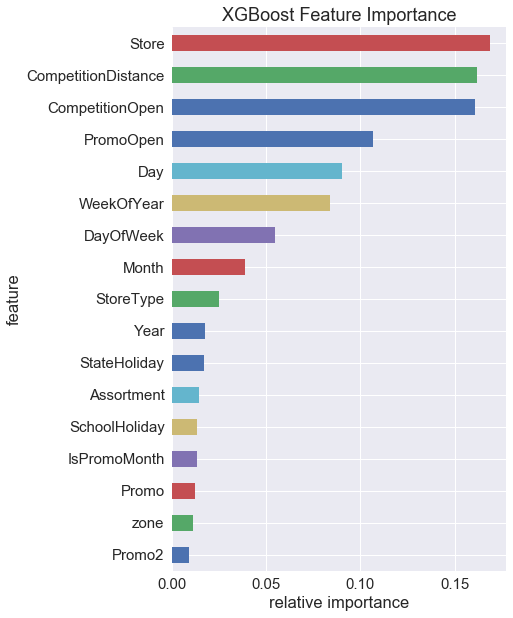

In [35]:
# XGB feature importances
# Based on https://www.kaggle.com/mmueller/liberty-mutual-group-property-inspection-prediction/xgb-feature-importance-python/code

create_feature_map(features)
importance = model_final.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
fig_featp = featp.get_figure()
fig_featp.savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)

### Future work


In [ ]:
"""
# save for future work

from tqdm import tqdm # show features building progress
# need improvement:https://pandas.pydata.org/pandas-docs/version/0.21/generated/pandas.DataFrame.shift.html
# progress bar: tqdm
# build more features depending on time and sales

def build_time_features(features, train, test):
    train.set_index('Date',inplace=True)
    test.set_index('Date',inplace=True)
    train.sort_index(ascending = True,inplace=True)
    test.sort_index(ascending = True,inplace=True)
    features.append('prevyear_dps_med')
    for storeid in tqdm(train.Store.unique()):
        for promoid in train.Promo.unique():
                prevyear_dps=train[(train.Store==storeid)&(train.Promo==promoid)].groupby(id)[sales].shift(365)
                train.loc[(train.Store==storeid)&(train.Promo==promoid),'prevyear_dps_med']=prevyear_dps
                test.loc[(test.Store==storeid)&(test.Promo==promoid),'prevyear_dps_med'] = prevyear_dps
    return train,test

build_time_features(features, train_data,test_data)

"""